# Problem Statement





ERC is a task that aims at predicting emotion of each utterance in a conversation. The following is an excerpt of a conversation with each utterance tagged with corresponding emotion and sentiment label.

![alt text](example.jpg "Title")


# Hierarchical Transformer Network for Utterance-Level Emotion Recognition
This is the Pytorch implementation Utterance-level Emotion Recognition [paper](https://arxiv.org/ftp/arxiv/papers/2002/2002.07551.pdf)

Overview
Though predicting the emotion of a single utterance or sentence, i.e. emotion detection, is a well discussed subject in natural language understanding literature, EmoContext has several novel challenges. In this paper, we address four challenges in utterance-level emotion recognition in dialogue systems:

- Emotion depend on the context of previous utterances in the dialogue

- long-range contextual information is hard to be effectively captured;

- Datasets are quite small.

- the class distribution of training data is significantly different from that of the test data. Consequently, a model trained on the training data might not perform well on the test data.

- We propose a hierarchical transformer framework with a lower-level transformer to model the word-level inputs and an upper-level transformer to capture the contexts of utterance-level embeddings.

# EmotionPush Dataset
Dataset includes the training data set consisting of 713 dialogues, and two evaluation data sets, Dev and Test, containing
99 and 85 dialogues respectively. The Training, validation and test datasets are json files containing following information :

 - Speaker - Identifies the speaker of utterance
 - Utterance -  The textual content of the utterance.
 - Emotion - Emotion labels for each utterance
 - Annotation - The annotation string contains the raw count of votes for each emotion by the annotators. The order of the emotions in the string is [neutral, joy, sadness, fear, anger,  surprise, disgust]. For example, string "2000030" denotes that two annotators voted for "neutral", and three voted for "surprise". Note that the sum of the votes is always five, since the dialogues were annotated by five annotators.

Dataset stattistics:




| Statistics | Train | Dev | Test | 
| :-| :- | :- | :- | 
| # of Dialogues | 720 | 80 |200 | 
| # of Utterances | 10733 | 1202 |2807 | 
| Min number of Utterances per dialogue| 6 | 6 |5 | 
| Max number of Utterances per dialogue| 24 | 24 |24 | 
| Average number of Utterances per dialogue| 14.91 | 15.02 |14.04 | 
| Min Utterance length | 0 | 133 |5.96 | 
| Max Utterance length | 1 | 183 |6.15 | 
| Average Utterance length | 0 | 71 |6.37 | 




    
    

In [1]:
import torch
import os
import random
import pandas as pd
import functools
import time
import math
import argparse
import json
import matplotlib
import matplotlib.patches as patches

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from ipywidgets import interact
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from transformers import DistilBertModel, DistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizer
from transformers import AutoModel, AutoTokenizer
from transformers import AutoConfig, AutoModelForPreTraining, AutoModelForSequenceClassification

from collections import defaultdict

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from sklearn.preprocessing import OneHotEncoder

from tabulate import tabulate
from bs4 import BeautifulSoup
import unidecode
from tqdm import tqdm
import re, string, json
from symspellpy.symspellpy import SymSpell, Verbosity
import pkg_resources
import spacy
import nltk
from collections import Counter
from deep_translator import GoogleTranslator
from sklearn.metrics import confusion_matrix

In [2]:
def get_args():
    """
        returns the Parser args
    """
    root_dir = os.getcwd()  
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type=int, default=8)  # Batch Size
    parser.add_argument('--projection_size', type=int, default=768) 
    parser.add_argument('--n_layers', type=int, default=4)
    parser.add_argument('--dropout', type=float, default=0.1)
    parser.add_argument('--lr', type=float, default=2e-5)
    parser.add_argument('--layerwise_decay', default=0.95, type=float,  
                    help='layerwise decay factor for the learning rate of the pretrained DistilBert')
    parser.add_argument('--epochs', type=int, default=3,
                        help='number of total epochs to run')
    parser.add_argument('--alpha', type=float, default=0.95)
    parser.add_argument('--seed', type=int, default=123,
                       help='seed for initializing training')
    parser.add_argument('--device', type=int, default=0)
    parser.add_argument('--gpu', type=str, default='0',		# Spcify the GPU for training
                        help='gpu: default 0')

    parser.add_argument('--speaker_embedding',  action="store_true",
                        help = 'Enable Speaker Embedding')
  
    parser.add_argument('--use_distilbert',  action="store_false",
                        help = 'Use DistilBert for German Text Encoding')
    parser.add_argument('--balance_weight_warming',  action="store_false",
                        help = 'Use balancec weight warming for loss function')
  
    parser.add_argument('--emoset', type=str, default = 'emotionpush',  # Emoset to choose
                        help = 'Emotion Training Set Name')
    args = parser.parse_args(args=[ '--speaker_embedding','--emoset', 'emotionpush'])
    
        
    return args

In [3]:
args = get_args()
print(args, '\n')
args.emoset = args.emoset.lower()
assert args.emoset  in ['emorynlp', 'emotionpush', 'friends','semeval', 'friends_german',
                        'emotionpush_german', 'emorynlp_german', 'semeval_german']
if args.emoset == 'semeval':
    args.speaker_embedding = False 

if not args.emoset == 'semeval':
    args.batch_size = 1
    
if args.emoset not in ['friends_german', 'emotionpush_german', 'emorynlp_german']:
    args.use_distilbert = False
    
pd.options.display.max_seq_items = 500
np.set_printoptions(threshold=500)

if args.emoset == 'friends' or args.emoset == 'friends_german':
        args.max_seq_len = 40
        args.balance_weight_warming =False
elif args.emoset == 'emotionpush' or args.emoset == 'emotionpush_german':
    args.max_seq_len = 35
    args.balance_weight_warming =False
elif args.emoset == 'emorynlp' or args.emoset == 'emorynlp_german':
    args.max_seq_len = 30
    args.balance_weight_warming =True
if args.emoset == 'semeval' or args.emoset == 'semeval_german':
    args.max_seq_len = 25
    args.balance_weight_warming =True

Namespace(alpha=0.95, balance_weight_warming=True, batch_size=8, device=0, dropout=0.1, emoset='emotionpush', epochs=3, gpu='0', layerwise_decay=0.95, lr=2e-05, n_layers=4, projection_size=768, seed=123, speaker_embedding=True, use_distilbert=True) 



## Set Environment Variables Like Random Seed, Cuda Device , Coloring Scheme

In [4]:
# Set the seed for deterministic behavior
seed = args.seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
seed_everything(42, workers=True)

# Set cuda device
device = torch.device("cuda:{}".format(int(args.gpu)) if torch.cuda.is_available() else "cpu")
args.device = device
print('Args.device = {}'.format(args.device))

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8



Global seed set to 42


Args.device = cuda:0


# Read Dataset CSV Files

In [5]:
'''
  Create Pandas Dataframe from EmoryNLP Dataset Json Files
  Parameters
    ----------
    Data : Json File 
        Json File containing Train/Val/Test Data
    Column_list : Python List
        Column list for the created dataframe    
    Returns
    -------
   df: Pandas Dataframe
'''

def create_df_emorynlp(data, column_list):
    df = pd.DataFrame(columns = column_list)
    dialogue_idx = 0
    episode_idx = 0
    for episode in data['episodes']:
        scenes = episode['scenes']
        for i in range(len(scenes)):
            for j in range(len(scenes[i]['utterances'])):
                df2 = pd.DataFrame([[dialogue_idx, scenes[i]['utterances'][j]['transcript'] , scenes[i]['utterances'][j]['speakers'][0], len(scenes[i]['utterances'][j]['transcript'].split()), scenes[i]['utterances'][j]['emotion'].lower() ]], columns = column_list)
                df = df.append(df2, ignore_index=True)
            dialogue_idx += 1
                    
        episode_idx = episode_idx+1
        
    return df

'''
  Create Pandas Dataframe from Friends/EmotionPush Dataset Json Files
   Parameters
    ----------
    Data : Json File 
        Json File containing Train/Val/Test Data
    Column_list : Python List
        Column list for the created dataframe    
    Returns
    -------
   df: Pandas Dataframe
'''
def create_df_friends(data, column_list):
    df = pd.DataFrame(columns = column_list)
    dialogue_idx = 0
    for dialog in data:
        for utter in dialog:
            df2 = pd.DataFrame([[dialogue_idx, utter['utterance'], utter['speaker'], len(utter['utterance'].split()), utter['emotion'].lower() ]], columns = column_list)
            df = df.append(df2, ignore_index=True)
        dialogue_idx += 1

    return df

def create_df(data, emoset):
    column_list = list(('dialogue_id', 'utterance', 'speaker','utterance_len', 'label'))
    if emoset == 'emorynlp':
        df=  create_df_emorynlp(data, column_list)
    elif emoset == 'friends' or emoset == 'emotionpush':
        df = create_df_friends(data, column_list)
     
    return df

'''
  Create Pandas Dataframe for Train, Validation and Test Data from Dataset Json Files
  
'''
def load_df(args):
    
    if args.emoset == 'emorynlp':
        print('Creating Training/Val/Test Dataframesfor EmoryNLP Dataset')
        train_path = '../data/EmoryNLP/English/emotion-detection-trn.json'
        val_path = '../data/EmoryNLP/English/emotion-detection-dev.json'
        test_path = '../data/EmoryNLP/English/emotion-detection-tst.json'
        
    elif args.emoset == 'emorynlp_german':
        print('Creating Training/Val/Test Dataframesfor EmoryNLP German Dataset')
        train_path = '../data/EmoryNLP/German/emorynlp_train_de.csv'
        val_path = '../data/EmoryNLP/German/emorynlp_val_de.csv'
        test_path = '../data/EmoryNLP/German/emorynlp_test_de.csv'

    elif  args.emoset == 'friends': 
        print('Creating Training/Val/Test Dataframes for Friends Dataset')
        train_path = '../data/Friends/Friends_English/friends.train.json'
        val_path = '../data/Friends/Friends_English/friends.dev.json'
        test_path = '../data/Friends/Friends_English/friends.test.json'
    elif args.emoset == 'friends_german':
        print('Creating Training/Val/Test Dataframes for Friends German Dataset')
        train_path = '../data/Friends/Friends_German/friends_train_de.csv'
        val_path = '../data/Friends/Friends_German/friends_val_de.csv'
        test_path = '../data/Friends/Friends_German/friends_test_de.csv'
        
    elif  args.emoset == 'emotionpush':
        print('Creating Training/Val/Test Dataframes for EmotionPush Dataset')
        train_path = '../data/Emotionpush/English/emotionpush.train.json'
        val_path =   '../data/Emotionpush/English/emotionpush.dev.json'
        test_path =  '../data/Emotionpush/English/emotionpush.test.json'
    
    elif args.emoset == 'emotionpush_german':
        print('Creating Training/Val/Test Dataframes for Emotionpush German Dataset')
        train_path = '../data/Emotionpush/German/emotionpush_train_de.csv'
        val_path =   '../data/Emotionpush/German/emotionpush_val_de.csv'
        test_path =  '../data/Emotionpush/German/emotionpush_test_de.csv'
          
    else:
        print('Creating Training/Val/Test Dataframes for Semeval Dataset')
        train_path = '../data/clean_train.txt'
        val_path = '../data/clean_val.txt'
        test_path = '../data/clean_test.txt'

    if args.emoset in ['friends', 'emotionpush', 'emorynlp'] :
        with open(train_path, encoding='utf-8') as data_file:
            train_json = json.loads(data_file.read())
        
        with open(val_path, encoding='utf-8') as data_file:
            val_json = json.loads(data_file.read())
        
        with open(test_path, encoding='utf-8') as data_file:
            test_json = json.loads(data_file.read())
        
        df_train = create_df(train_json, args.emoset)
        df_val = create_df(val_json,  args.emoset)       
        df_test = create_df(test_json,  args.emoset) 
    elif args.emoset == 'semeval':
        df_train = pd.read_csv(train_path, delimiter='\t', index_col='id')
        df_val =  pd.read_csv(val_path, delimiter='\t', index_col='id')    
        df_test = pd.read_csv(test_path, delimiter='\t', index_col='id')
       
    else:
        df_train = pd.read_csv(train_path)
        df_val =  pd.read_csv(val_path)    
        df_test = pd.read_csv(test_path)
        df_train = df_train.dropna()
        df_val = df_val.dropna()
        df_test = df_test.dropna()
        col_dict = {'emotion': 'label'}   ## key→old name, value→new name
        df_train.columns = [col_dict.get(x, x) if x in col_dict.keys() else x  for x in df_train.columns]
        df_val.columns = [col_dict.get(x, x) if x in col_dict.keys() else x  for x in df_val.columns]
        df_test.columns = [col_dict.get(x, x) if x in col_dict.keys() else x  for x in df_test.columns]
        #df_train.rename(columns={'emotion':'label'}, inplace=True)
        df_train['utterance_len'] = df_train[['utterance_de_deepl']].applymap(lambda x: len(x.split()))
        df_val['utterance_len'] = df_val[['utterance_de_deepl']].applymap(lambda x: len(x.split()))
        df_test['utterance_len'] = df_test[['utterance_de_deepl']].applymap(lambda x: len(x.split()))
                
    return (df_train, df_val, df_test)
    

# Load Datasets

In [6]:

(df_train, df_val, df_test)  = load_df(args)   

Creating Training/Val/Test Dataframes for EmotionPush Dataset


In [7]:
df_train

,dialogue_id,utterance,speaker,utterance_len,label
0,0,Sorry to bother you but do you have the 270 te...,100000497930502,11,neutral
1,0,What's it called,100000222851837,3,neutral
2,0,Digital design and principles I think,100000497930502,6,neutral
3,0,I don't think so?,100000222851837,4,neutral
4,0,I could be wrong,100000222851837,4,neutral
...,...,...,...,...,...
10728,719,It's Young Money,100001916687499,3,neutral
10729,719,Oh I was looking down near the 73s,100000218198096,8,surprise
10730,719,You're at 86,100000218198096,3,neutral
10731,719,Yea but idk if the 15% you get off for handing...,100001916687499,19,neutral


### We define 3 set of dictionaries
- emodict : Enumerate the emotions present in the dataset
- focus_dict : Enumerate the smaller subset of emotions that we want to focus on
- sentiment dict : Enumerate the sentiment associated with the emotion

For EmoryNLP Dataset, we train the model to learn all 7 emotions present in the dataset.

In [8]:
if args.emoset == 'emorynlp' or args.emoset == 'emorynlp_german':
    emo_dict= {'neutral': 0, 'sad': 1, 'mad':2, 'joyful':3, 'peaceful':4,'powerful':5, 'scared':6}
    focus_dict = ['neutral', 'sad', 'mad', 'joyful', 'peaceful', 'powerful', 'scared']
    sentiment_dict = {'neutral': 0, 'sad': 1, 'mad':1, 'joyful':2, 'peaceful':2,'powerful':2, 'scared':1}
elif args.emoset == 'friends' or args.emoset == 'friends_german':

    emo_dict = {'neutral': 0, 'sadness': 1, 'anger':2, 'joy':3, 'non-neutral':4,'surprise':5, 'fear':6, 'disgust':7}
    focus_dict = ['neutral', 'sadness', 'anger', 'joy']
    sentiment_dict = {'neutral': 0, 'sadness': 1, 'anger':1, 'joy':2, 'non-neutral':0, 'surprise':2,'fear':1, 'disgust':1}
elif args.emoset == 'emotionpush' or args.emoset == 'emotionpush_german':
  
    emo_dict = {'neutral': 0, 'sadness': 1, 'anger':2, 'joy':3, 'non-neutral':4,'surprise':5, 'fear':6, 'disgust':7}
    focus_dict = ['neutral', 'sadness', 'anger', 'joy']
    sentiment_dict = {'neutral': 0, 'sadness': 1, 'anger':1, 'joy':2, 'non-neutral':0, 'surprise':2,'fear':1, 'disgust':1}
elif args.emoset == 'semeval':

    emo_dict = {'others': 0, 'sad': 1, 'angry':2, 'happy':3}
    focus_dict = ['sad', 'angry', 'happy']
    sentiment_dict = {'others': 0, 'sad': 1, 'angry':1, 'happy':2}

    
print('Emotion Mapping {}'.format(emo_dict))
print('Focus Emotion {}'.format(focus_dict))
emo_count = {}
for emo in emo_dict.keys():
        emo_count[emo] =df_train['label'].value_counts()[emo]
print('Emotion Label Distribution in Training Set {}'.format(emo_count))

emo_count = {}
for emo in emo_dict.keys():
        emo_count[emo] =df_val['label'].value_counts()[emo]
print('Emotion Label Distribution in Validation Set {}'.format(emo_count))
emo_count = {}
for emo in emo_dict.keys():
    emo_count[emo] =df_test['label'].value_counts()[emo]
print('Emotion Label Distribution in Test Set {}'.format(emo_count))

Emotion Mapping {'neutral': 0, 'sadness': 1, 'anger': 2, 'joy': 3, 'non-neutral': 4, 'surprise': 5, 'fear': 6, 'disgust': 7}
Focus Emotion ['neutral', 'sadness', 'anger', 'joy']
Emotion Label Distribution in Training Set {'neutral': 7148, 'sadness': 389, 'anger': 94, 'joy': 1482, 'non-neutral': 1064, 'surprise': 435, 'fear': 36, 'disgust': 85}
Emotion Label Distribution in Validation Set {'neutral': 825, 'sadness': 38, 'anger': 9, 'joy': 160, 'non-neutral': 121, 'surprise': 39, 'fear': 4, 'disgust': 6}
Emotion Label Distribution in Test Set {'neutral': 1882, 'sadness': 87, 'anger': 37, 'joy': 458, 'non-neutral': 233, 'surprise': 93, 'fear': 2, 'disgust': 15}


#  Number of Dialogues in Training and Evaluation Sets

In [47]:
if not args.emoset == 'semeval':
    print ( '{} {} {}' .format(len(df_train['dialogue_id'].unique()), len(df_val['dialogue_id'].unique()), len(df_test['dialogue_id'].unique())))

720 80 200


#  Number of utterances in Training and Evaluation Sets

In [48]:
df_train.shape[0], df_val.shape[0], df_test.shape[0]

(10733, 1202, 2807)

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10733 entries, 0 to 10732
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dialogue_id    10733 non-null  object
 1   utterance      10733 non-null  object
 2   speaker        10733 non-null  object
 3   utterance_len  10733 non-null  object
 4   label          10733 non-null  object
dtypes: object(5)
memory usage: 419.4+ KB


##  Comparison of class distribution in Training vs Evaluation data sets

| Emotion | Neutral | Sad | Anger(Mad) | Joy | Non-neutral | disgust | fear| surprise| # |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |:-: |
| Train | 7148 |389 | 94| 1482|1064 |85 | 36| 435| 10733|
| Dev | 825 |38 | 9| 160|121 |6 | 4| 39|1202|
| Test | 1882 |87 | 37| 458|233 |15 | 2| 93|2807|

[Text(0, 0, 'neutral'),
 Text(1, 0, 'sadness'),
 Text(2, 0, 'anger'),
 Text(3, 0, 'joy'),
 Text(4, 0, 'non-neutral'),
 Text(5, 0, 'disgust'),
 Text(6, 0, 'fear'),
 Text(7, 0, 'surprise')]

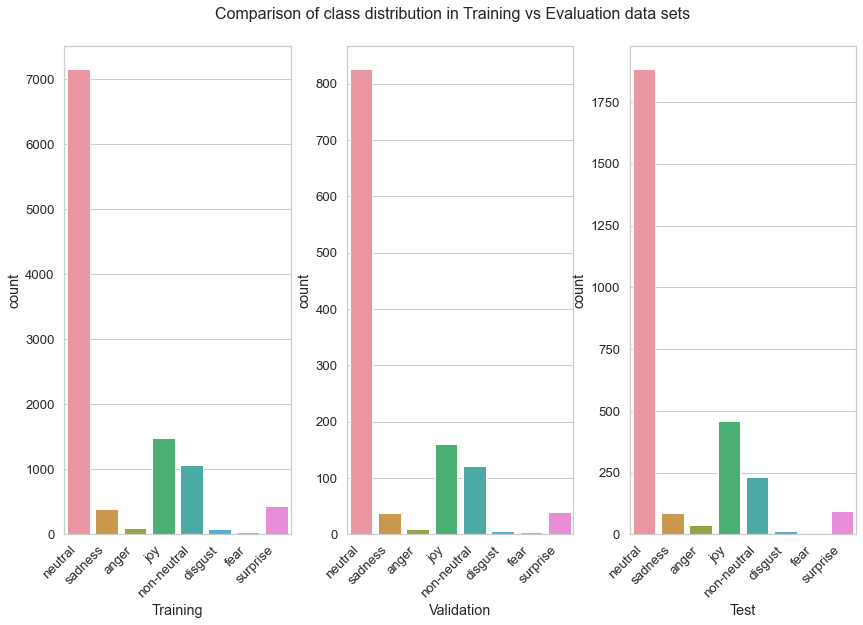

In [22]:
data = [df_train['label'], df_val['label'], df_test['label']]
columns=list(('Training', 'Validation', 'Test'))
df_labels = pd.concat(data, axis=1, keys=columns)

fig, ax =plt.subplots(1,3)
fig.suptitle('Comparison of class distribution in Training vs Evaluation data sets', fontsize=16)
fig.tight_layout()
if args.emoset == 'friends' or args.emoset == 'emotionpush':
    emotion_list = ['neutral', 'sadness', 'anger', 'joy', 'non-neutral', 'disgust', 'fear', 'surprise' ]
elif args.emoset == 'emorynlp':
    emotion_list = ['neutral', 'sad', 'mad', 'joyful','peaceful', 'powerful', 'scared' ]
else:
    emotion_list = ['happy', 'sad', 'angry', 'others']
chart = sns.countplot(x="Training",   data=df_labels, order = emotion_list, ax=ax[0])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart = sns.countplot(x="Validation", data=df_labels, order = emotion_list, ax=ax[1])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart = sns.countplot(x="Test",       data=df_labels, order = emotion_list, ax=ax[2])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

# Scale of class imbalance is similar in Training and Evaluation data sets
| Emotion | Neutral | Sad | Anger(Mad) | Joy | Non-neutral | disgust | fear| surprise|
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |   
| Train | 66% | 4% |1% | 14%| 10% |1% |0% | 4%| 
| Dev | 69% | 3% |1% | 13%| 10%|1% |0% | 3%|
| Test | 67% | 3% |1% | 16%| 9%|1% |0% | 3%|

Distribution of classes is almost similar among training and eval sets

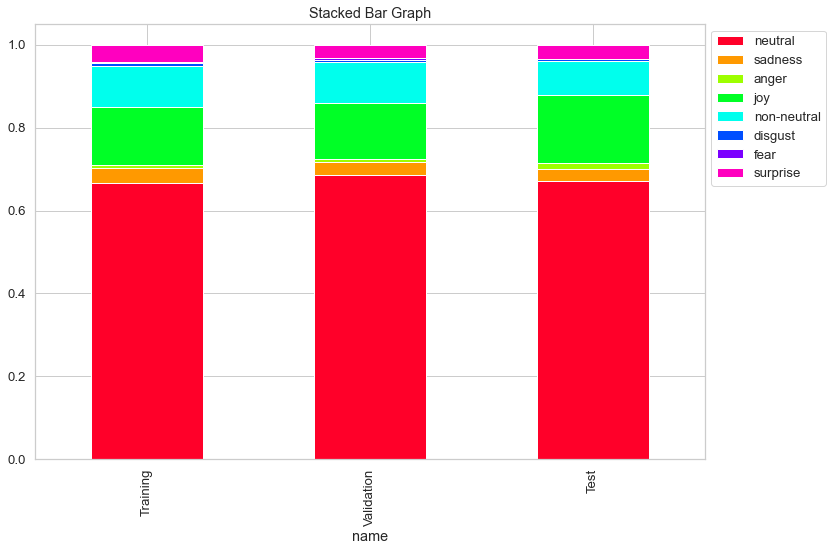

In [23]:
train = pd.Series(['Training'] , ['name'])
train = train.append(df_labels['Training'].value_counts().div(df_labels['Training'].value_counts().sum()))
val = pd.Series(['Validation'] , ['name'])
val = val.append(df_labels['Validation'].value_counts().div(df_labels['Validation'].value_counts().sum()))
test = pd.Series(['Test'] , ['name'])
test = test.append(df_labels['Test'].value_counts().div(df_labels['Test'].value_counts().sum()))

df_stacked = pd.DataFrame(columns = emotion_list)

df_stacked = df_stacked.append(train,ignore_index=True)
df_stacked = df_stacked.append(val,ignore_index=True)
df_stacked = df_stacked.append(test,ignore_index=True)
# plot a Stacked Bar Chart using matplotlib
df_stacked.plot(
    x = 'name',
    kind = 'bar',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = False, 
    colormap='gist_rainbow'
   ).legend(bbox_to_anchor=(1, 1))

# Distribution of number of utterances per dialogue in Train and Evaluation Sets



In [24]:
train_dialogue_id_list = list((df_train['dialogue_id'].unique()))
val_dialogue_id_list = list((df_val['dialogue_id'].unique()))
test_dialogue_id_list = list((df_test['dialogue_id'].unique()))
d = {"Training":[],"Validation":[],"Test":[] };
for dialogue in train_dialogue_id_list:
     d['Training'].append((df_train.dialogue_id ==dialogue).sum())
for dialogue in val_dialogue_id_list:
     d['Validation'].append((df_val.dialogue_id ==dialogue).sum())
for dialogue in test_dialogue_id_list:
     d['Test'].append((df_test.dialogue_id ==dialogue).sum())




In [25]:

print('Train Set: Utterance per dialogue statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Training']), max(d['Training']), np.round(sum(d['Training'])/len(d['Training']), 2)))
print('Validation Set: Utterance per dialogue statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Validation']), max(d['Validation']), np.round(sum(d['Validation'])/len(d['Validation']), 2)))
print('Test Set: Utterance per dialogue statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Test']), max(d['Test']), np.round(sum(d['Test'])/len(d['Test']), 2)))

Train Set: Utterance per dialogue statistics : Min: 6, Max: 24 Avg: 14.91
Validation Set: Utterance per dialogue statistics : Min: 6, Max: 24 Avg: 15.02
Test Set: Utterance per dialogue statistics : Min: 5, Max: 24 Avg: 14.04


<AxesSubplot:title={'center':'Test'}, ylabel='Count'>

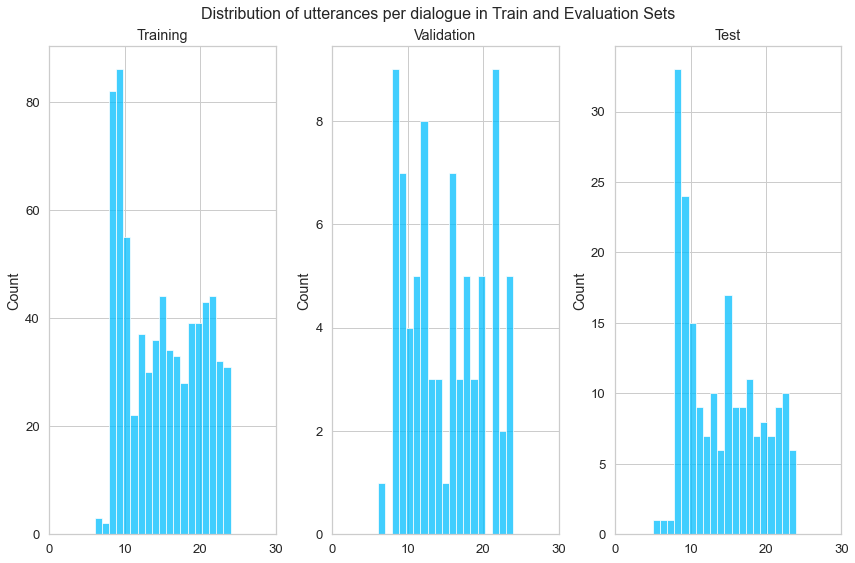

In [26]:
fig, ax =plt.subplots(ncols=3)
fig.suptitle('Distribution of utterances per dialogue in Train and Evaluation Sets', fontsize=16)
fig.tight_layout()
bins = [0] * 3
if args.emoset == 'friends':
    bins[0] = 20
    bins[1] = 20
    bins[2] = 20
elif args.emoset == 'emotionpush':
    bins[0] = 19
    bins[1] = 19
    bins[2] = 20
elif args.emoset == 'emorynlp':
    bins[0] = 20
    bins[1] = 20
    bins[2] = 20

ax[0].set_title('Training')
ax[0].set_xlim([0, 30])
sns.histplot(d['Training'] , ax=ax[0], bins= bins[0], stat = 'count' )

ax[1].set_title('Validation')
ax[1].set_xlim([0, 30])
sns.histplot(d['Validation'] , ax=ax[1], bins= bins[1], stat = 'count')

ax[2].set_title('Test')
ax[2].set_xlim([0, 30])
sns.histplot(d['Test'] , ax=ax[2], bins= bins[2], stat = 'count')


# Distribution of Utterance Length in Train and Evaluation Sets
- Length of utterances follows almost similar distribution in train and evaluation datasets


In [27]:
d = {"Training":[],"Validation":[],"Test":[] }

if not args.emoset == 'semeval':
    d['Training'] = list(df_train['utterance_len'].values)
    d['Validation'] = list(df_val['utterance_len'].values)
    d['Test'] = list(df_test['utterance_len'].values)
else:
    for col in ['turn1', 'turn2', 'turn3']:
        for tokens in df_train[col]:
            d['Training'].append(len(tokens.split()))
        for tokens in df_val[col]:
            d['Validation'].append(len(tokens.split()))
        for tokens in df_test[col]:
            d['Test'].append(len(tokens.split()))
        

Minimum and maximum value of utterance length in train, val and test sets

In [28]:
print('Train Set: Utterance length statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Training']), max(d['Training']), np.round(sum(d['Training'])/len(d['Training']), 2)))
print('Validation Set: Utterance length statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Validation']), max(d['Validation']), np.round(sum(d['Validation'])/len(d['Validation']), 2)))
print('Test Set: Utterance length statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Test']), max(d['Test']), np.round(sum(d['Test'])/len(d['Test']), 2)))

Train Set: Utterance length statistics : Min: 0, Max: 133 Avg: 5.96
Validation Set: Utterance length statistics : Min: 1, Max: 183 Avg: 6.15
Test Set: Utterance length statistics : Min: 0, Max: 71 Avg: 6.37


In [29]:
print('99 percentile for Training Data {}'.format(np.percentile(np.asarray(d['Training']), 99)))
print('99 percentile for Validation Data {}'.format(np.percentile(np.asarray(d['Validation']), 99)))
print('99 percentile for Test Data {}'.format(np.percentile(np.asarray(d['Test']), 99)))

99 percentile for Training Data 26.0
99 percentile for Validation Data 28.0
99 percentile for Test Data 29.0


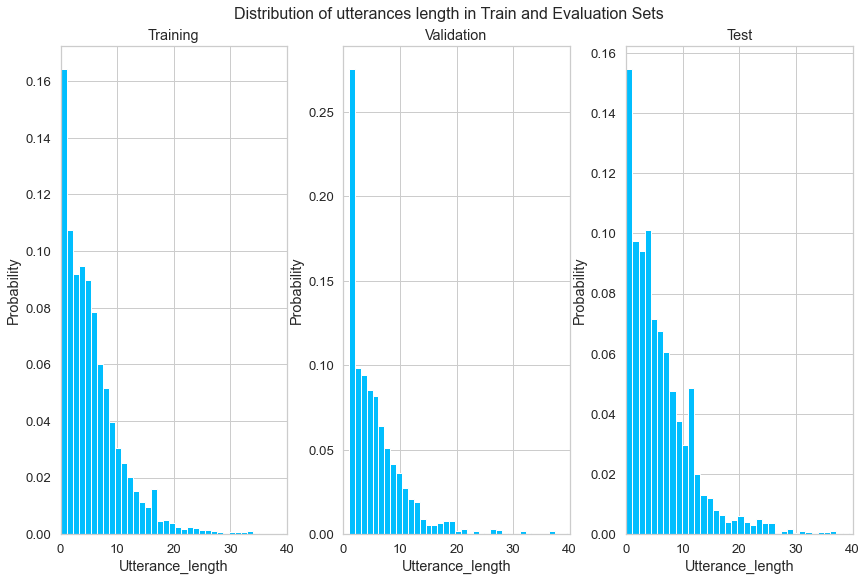

In [30]:
fig, ax =plt.subplots(1,3)
fig.suptitle('Distribution of utterances length in Train and Evaluation Sets', fontsize=16)
fig.tight_layout()

if args.emoset == 'friends':
    ax[0].set_title('Training')
    ax[0].set_xlim([0, 40])
    ax[0].set(xlabel='Utterance_length', ylabel='Probability')
    ax[0].hist(d['Training'], bins = 50, density = True)

    ax[1].set_title('Validation')
    ax[1].set_xlim([0, 40])
    ax[1].hist(d['Validation'], bins = 27, density = True)
    ax[1].set(xlabel='Utterance_length', ylabel='Probability')


    ax[2].set_title('Test')
    ax[2].set_xlim([0, 40])
    ax[2].hist(d['Test'], bins = 32, density = True)
    ax[2].set(xlabel='Utterance_length', ylabel='Probability')
elif args.emoset == 'emotionpush':
    ax[0].set_title('Training')
    ax[0].set_xlim([0, 40])
    ax[0].set(xlabel='Utterance_length', ylabel='Probability')
    ax[0].hist(d['Training'], bins = 125, density = True)

    ax[1].set_title('Validation')
    ax[1].set_xlim([0, 40])
    ax[1].hist(d['Validation'], bins = 175, density = True)
    ax[1].set(xlabel='Utterance_length', ylabel='Probability')


    ax[2].set_title('Test')
    ax[2].set_xlim([0, 40])
    ax[2].hist(d['Test'], bins = 65, density = True)
    ax[2].set(xlabel='Utterance_length', ylabel='Probability')
elif args.emoset == 'emorynlp':
    ax[0].set_title('Training')
    ax[0].set_xlim([0, 60])
    ax[0].set(xlabel='Utterance_length', ylabel='Probability')
    ax[0].hist(d['Training'], bins = 100, density = True)

    ax[1].set_title('Validation')
    ax[1].set_xlim([0, 60])
    ax[1].hist(d['Validation'], bins = 50, density = True)
    ax[1].set(xlabel='Utterance_length', ylabel='Probability')


    ax[2].set_title('Test')
    ax[2].set_xlim([0, 60])
    ax[2].hist(d['Test'], bins = 55, density = True)
    ax[2].set(xlabel='Utterance_length', ylabel='Probability')

### Speaker_Embedding
Train/Validation/Test data sets have 6 prominent speakets. We can encode speaker information in two ways
 - Use one hot encoder to assign a unique value to each speaker
 - Change speaker name to unknow for any speaker outside the list of most common speakers. USe one hot encoder to encode 'First Siy Speakers' + 'Unknown'
 
We choose the first approach.

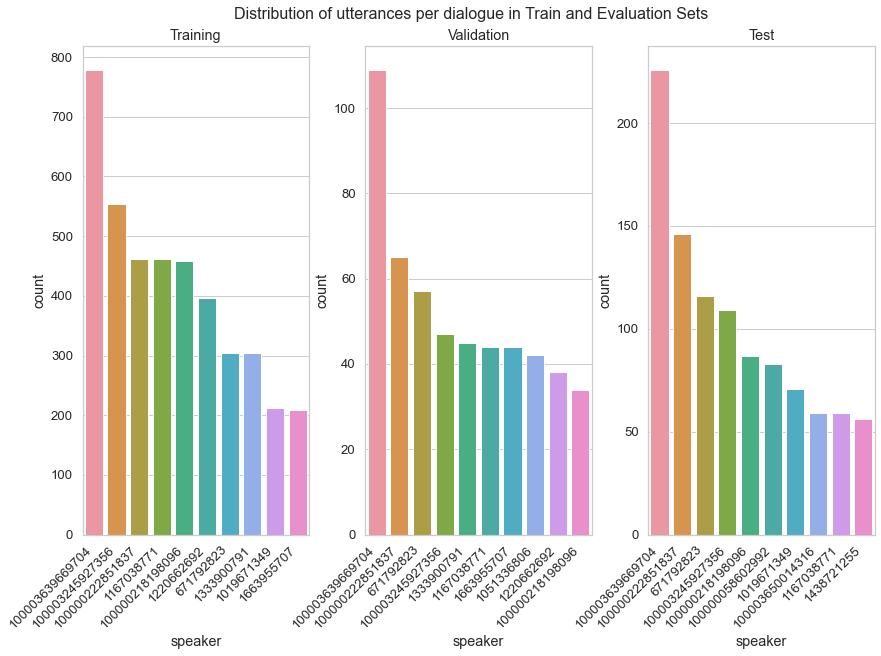

In [31]:
if not args.emoset == 'semeval':
    fig, ax =plt.subplots(ncols=3)
    fig.suptitle('Distribution of utterances per dialogue in Train and Evaluation Sets', fontsize=16)
    fig.tight_layout()
    ax[0].set_title('Training')
    chart = sns.countplot(data=df_train, x='speaker', order=df_train.speaker.value_counts().index[0:10], ax = ax[0])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

    ax[1].set_title('Validation')
    chart = sns.countplot(data=df_val, x='speaker', order=df_val.speaker.value_counts().index[0:10], ax = ax[1])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

    ax[2].set_title('Test')
    chart =  sns.countplot(data=df_test, x='speaker', order=df_test.speaker.value_counts().index[0:10], ax = ax[2])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

# Data Normalization

Normalizing a natural language resource,helps in reducing the randomness in it, bringing it closer to a predefined “standard” and reducing the dimensionality of the input,

We use following normalization techniques:

- Removal of duplicate whitespaces and punctuation.
- Accent removal 
- Capital letter removal 
- Removal or substitution of special characters/emojis 
- Substitution of contractions (very common in English; e.g.: ‘I’m’→‘I am’).
- Transform word numerals into numbers (eg.: ‘fifty three’→‘53’).
- Removal of gender/time/grade variation with Stemming or Lemmatization.



In [32]:
from symspellpy.symspellpy import SymSpell, Verbosity
import pkg_resources
import re, string, json
import spacy
from tqdm.notebook import tqdm

def simplify_punctuation_and_whitespace(sentence_list):
    norm_sents = []
    print("Normalizing whitespaces and punctuation")
    for sentence in tqdm(sentence_list):
        sent = _replace_urls(sentence)
        sent = _simplify_punctuation(sentence)
        sent = _normalize_whitespace(sent)
        norm_sents.append(sent)
    return norm_sents

def _replace_urls(text):
    url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    text = re.sub(url_regex, "<URL>", text)
    return text

def _simplify_punctuation(text):
    """
    This function simplifies doubled or more complex punctuation. The exception is '...'.
    """
    corrected = str(text)
    corrected = re.sub(r'([!?,;])\1+', r'\1', corrected)
    corrected = re.sub(r'\.{2,}', r'...', corrected)
    return corrected

def _normalize_whitespace(text):
    """
    This function normalizes whitespaces, removing duplicates.
    """
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")

def normalize_contractions(sentence_list):
    contraction_list = json.loads(open('english_contractions.json', 'r').read())
    norm_sents = []
    print("Normalizing contractions")
    for sentence in tqdm(sentence_list):
        norm_sents.append(_normalize_contractions_text(sentence, contraction_list))
    return norm_sents

def _normalize_contractions_text(text, contractions):
    """
    This function normalizes english contractions.
    """
    new_token_list = []
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        first_upper = False
        if word[0].isupper():
            first_upper = True
        if word.lower() in contractions:
            replacement = contractions[word.lower()]
            if first_upper:
                replacement = replacement[0].upper()+replacement[1:]
            replacement_tokens = replacement.split()
            if len(replacement_tokens)>1:
                new_token_list.append(replacement_tokens[0])
                new_token_list.append(replacement_tokens[1])
            else:
                new_token_list.append(replacement_tokens[0])
        else:
            new_token_list.append(word)
    sentence = " ".join(new_token_list).strip(" ")
    return sentence

def spell_correction(sentence_list):
    max_edit_distance_dictionary= 3
    prefix_length = 4
    spellchecker = SymSpell(max_edit_distance_dictionary, prefix_length)
    dictionary_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_dictionary_en_82_765.txt")
    bigram_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
    spellchecker.load_dictionary(dictionary_path, term_index=0, count_index=1)
    spellchecker.load_bigram_dictionary(dictionary_path, term_index=0, count_index=2)
    norm_sents = []
    print("Spell correcting")
    for sentence in tqdm(sentence_list):
        norm_sents.append(_spell_correction_text(sentence, spellchecker))
    return norm_sents

def _spell_correction_text(text, spellchecker):
    """
    This function does very simple spell correction normalization using pyspellchecker module. It works over a tokenized sentence and only the token representations are changed.
    """
    if len(text) < 1:
        return ""
    #Spell checker config
    max_edit_distance_lookup = 2
    suggestion_verbosity = Verbosity.TOP # TOP, CLOSEST, ALL
    #End of Spell checker config
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        if word is None:
            token_list[word_pos] = ""
            continue
        if not '\n' in word and word not in string.punctuation and not is_numeric(word) and not (word.lower() in spellchecker.words.keys()):
            suggestions = spellchecker.lookup(word.lower(), suggestion_verbosity, max_edit_distance_lookup)
            #Checks first uppercase to conserve the case.
            upperfirst = word[0].isupper()
            #Checks for correction suggestions.
            if len(suggestions) > 0:
                correction = suggestions[0].term
                replacement = correction
            #We call our _reduce_exaggerations function if no suggestion is found. Maybe there are repeated chars.
            else:
                replacement = _reduce_exaggerations(word)
            #Takes the case back to the word.
            if upperfirst:
                replacement = replacement[0].upper()+replacement[1:]
            word = replacement
            token_list[word_pos] = word
    return " ".join(token_list).strip()

def _reduce_exaggerations(text):
    """
    Auxiliary function to help with exxagerated words.
    Examples:
        woooooords -> words
        yaaaaaaaaaaaaaaay -> yay
    """
    correction = str(text)
    #TODO work on complexity reduction.
    return re.sub(r'([\w])\1+', r'\1', correction)

def is_numeric(text):
    for char in text:
        if not (char in "0123456789" or char in ",%.$"):
            return False
    return True

def lemmatize(sentence_list):
    new_norm=[]
    print("Lemmatizing Sentences")
    for sentence in tqdm(sentence_list):
        new_norm.append(_lemmatize_text(sentence, nlp).strip())
    return new_norm

def _lemmatize_text(sentence, nlp):
    sent = ""
    doc = nlp(sentence)
    for token in doc:
        if '@' in token.text:
            sent+=" @MENTION"
        elif '#' in token.text:
            sent+= " #HASHTAG"
        else:
            sent+=" "+token.lemma_
    return sent

def basic_string_manipulation(text):
    text = re.sub(r'[,;:?!-\(\)\[\].]+',' \g<0> ', text)
    return text

def count_num_tokens(text):
    tokens = text.split()
    return len(tokens)

def generate_dict_from_text(text):
    tokens = text.split()
    word_freq_dic= {}
    for token in tokens:
        word_freq_dic[token]= word_freq_dic.get(token, 1)+1
    return word_freq_dic

def num_distinct_tokens(text):
    tokens = text.split()
    dist_tokens = set()
    for token in tokens:
        dist_tokens.add(token)
    return len(dist_tokens)

def common_tokens(text, common_list):
    tokens = text.split()
    common_token_num = 0
    for token in tokens:
        if token in common_list:
            common_token_num+=1
    return common_token_num

def get_most_used_tokens(token_dict):
    #uses the 20-80 rule, where 20% of the words usually correspond to 80% of the total number of words.
    total_num_words = sum(token_dict.values())
    most_used = []
    total_most_used = 0
    word_iterator = iter(sorted(token_dict.items(), key=lambda x: x[1], reverse=True))
    while total_most_used < total_num_words*0.8:
        word_tuple = next(word_iterator)
        most_used.append(word_tuple[0])
        total_most_used+=word_tuple[1]
    return most_used

def normalization_pipeline(sentences):
    print("##############################")
    print("Starting Normalization Process")
    sentences = simplify_punctuation_and_whitespace(sentences)
    #sentences = normalize_contractions(sentences)
    #sentences = spell_correction(sentences)
    #sentences = lemmatize(sentences)
    print("Normalization Process Finished")
    print("##############################")
    return sentences

def text_preprocess(df):
    unormalized = list(df.utterance.values)
    normalized = normalization_pipeline(unormalized)
    unorm_df = pd.DataFrame(columns=['Text'], data=unormalized)
    norm_df = pd.DataFrame(columns=['Text'], data=normalized)
    unorm_df['Preprocessed'] = unorm_df['Text'].apply(lambda x: basic_string_manipulation(x))
    norm_df['Preprocessed'] = norm_df['Text'].apply(lambda x: basic_string_manipulation(x))
    norm_df['Size_in_Tokens']=unorm_df['Text'].apply(lambda x: count_num_tokens(x))
    df['utterance'] = norm_df['Text']
    df['utterance_len'] = norm_df['Size_in_Tokens']
    return df

We saw that doing any kind of preprocessing on text results in compartitively poorer performance. So we comment out this part of the code. 



In [33]:
'''
nlp = spacy.load('en_core_web_sm')
(df_train, df_val, df_test)  = load_df(args)   
df_train = text_preprocess(df_train)
df_val = text_preprocess(df_val)
df_test = text_preprocess(df_test)
'''

"\nnlp = spacy.load('en_core_web_sm')\n(df_train, df_val, df_test)  = load_df(args)   \ndf_train = text_preprocess(df_train)\ndf_val = text_preprocess(df_val)\ndf_test = text_preprocess(df_test)\n"

# Label Transition Probability Visualization
- To check for possible patterns in the label sequences of the datasets, we plot frequency of the label
  pairs (x;y) where x and y are the labels of ${U}_{s_{t-1}, t-1}$ and ${U}_{s_{t}, t}$ respectively
- Plot show the same emotion label or neutral label appearing in the consecutive utterances with high frequency. This may    
  induce label dependencies and consistencies and can be called as the label copying feature of the dataset.

In [34]:
'''
  Calculate and Visualize Label Transition Probabilities DataFrame
  Parameters
    ----------
    df : Pandas Dataframe 
        Pandas dataframe repersenting Train/Val/Test Data
    emo_dict : Python Dictionary
        Python Dictionary specifying the encoded value of emotion labels. 
  Returns
    -------
    None
'''


def VisualizeTransitionProb(df, emo_dict):
    
    sequence =  list(df.label)
    trans_mat= pd.crosstab( pd.Series(sequence[:-1], name='From State'),
                     pd.Series(sequence[1:], name='To State'),
                     normalize=0
                     )
    trans_mat = np.round(trans_mat, 2)
    trans_mat = trans_mat[emo_dict.keys()]
    trans_mat= trans_mat.reindex(emo_dict.keys())
    h = [trans_mat.index.names[0] +'/'+ trans_mat.columns.names[0]] + list(trans_mat.columns.tolist())
    print(tabulate(trans_mat, headers= h, tablefmt= 'grid'))
  
    myMatrix = trans_mat.to_numpy()
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')

    plt.style.use(['ggplot'])
    plt.ylabel('From State')
    plt.xlabel('To State')
    plt.title('Friends')
    mymap = plt.get_cmap("YlGnBu")
   
    normalize = matplotlib.colors.LogNorm(vmin=0.0001, vmax=1)
    normalize = matplotlib.colors.PowerNorm(gamma=0.5, vmin=0.01, vmax=1)
    matrix_size = myMatrix.shape[0]
    square_size = 1.0 / matrix_size

    diagonal = myMatrix.diagonal()
    

    ax.set_xticklabels(emo_dict.keys(), rotation=90, horizontalalignment='right')
    ax.set_yticklabels(list(reversed(emo_dict.keys())), rotation=0, horizontalalignment='right')

    ax.xaxis.set_ticks(np.arange(0 + 0.5 * square_size, 1 + 0.5 * square_size, square_size))
    ax.yaxis.set_ticks(np.arange(0 + 0.5 * square_size, 1 + 0.5 * square_size, square_size))

    # iterate over all elements of the matrix
    
    for i in range(matrix_size):
        for j in range(matrix_size):
            if myMatrix[i, j] > 0:
                rect_size = np.sqrt(myMatrix[i, j]) * square_size
            else:
                rect_size = 0

            dx = 0.5 * (square_size - rect_size)
            dy = 0.5 * (square_size - rect_size)
            #print(' {} {}'.format((i) * square_size + dx, j * square_size + dy))
            p = patches.Rectangle(
                (j * square_size + dy, (matrix_size-i-1) * square_size + dx),
                rect_size,
                rect_size,
                fill=True,
                color=mymap(normalize(myMatrix[i, j]))
            )
            ax.add_patch(p)

    cbax = fig.add_axes([0.85, 0.12, 0.05, 0.78])
    cb = matplotlib.colorbar.ColorbarBase(cbax, cmap=mymap, orientation='vertical')
    cb.set_label("Transition Probability")
    plt.show(block=True)
    plt.interactive(False)

+-----------------------+-----------+-----------+---------+-------+---------------+------------+--------+-----------+
| From State/To State   |   neutral |   sadness |   anger |   joy |   non-neutral |   surprise |   fear |   disgust |
+=======================+===========+===========+=========+=======+===============+============+========+===========+
| neutral               |      0.74 |      0.02 |    0.01 |  0.11 |          0.08 |       0.04 |   0    |      0.01 |
+-----------------------+-----------+-----------+---------+-------+---------------+------------+--------+-----------+
| sadness               |      0.5  |      0.21 |    0.01 |  0.1  |          0.13 |       0.03 |   0    |      0.01 |
+-----------------------+-----------+-----------+---------+-------+---------------+------------+--------+-----------+
| anger                 |      0.54 |      0.06 |    0.1  |  0.12 |          0.14 |       0.03 |   0    |      0.01 |
+-----------------------+-----------+-----------+-------

<ipython-input-34-ec4ce9faf0a1>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(emo_dict.keys(), rotation=90, horizontalalignment='right')
<ipython-input-34-ec4ce9faf0a1>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(emo_dict.keys())), rotation=0, horizontalalignment='right')


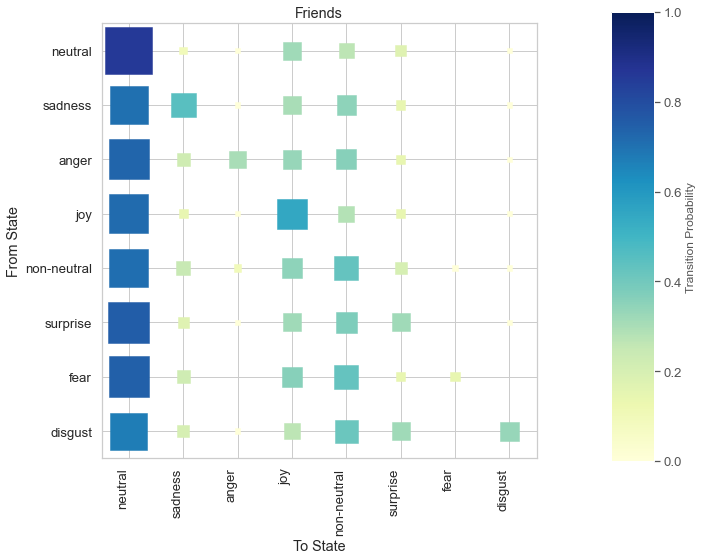

In [35]:
VisualizeTransitionProb(df_train, emo_dict)

+-----------------------+-----------+-----------+---------+-------+---------------+------------+--------+-----------+
| From State/To State   |   neutral |   sadness |   anger |   joy |   non-neutral |   surprise |   fear |   disgust |
+=======================+===========+===========+=========+=======+===============+============+========+===========+
| neutral               |      0.76 |      0.02 |    0.01 |  0.12 |          0.06 |       0.03 |      0 |      0    |
+-----------------------+-----------+-----------+---------+-------+---------------+------------+--------+-----------+
| sadness               |      0.46 |      0.22 |    0.01 |  0.13 |          0.15 |       0.03 |      0 |      0    |
+-----------------------+-----------+-----------+---------+-------+---------------+------------+--------+-----------+
| anger                 |      0.35 |      0.05 |    0.32 |  0.08 |          0.16 |       0    |      0 |      0.03 |
+-----------------------+-----------+-----------+-------

<ipython-input-34-ec4ce9faf0a1>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(emo_dict.keys(), rotation=90, horizontalalignment='right')
<ipython-input-34-ec4ce9faf0a1>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(emo_dict.keys())), rotation=0, horizontalalignment='right')


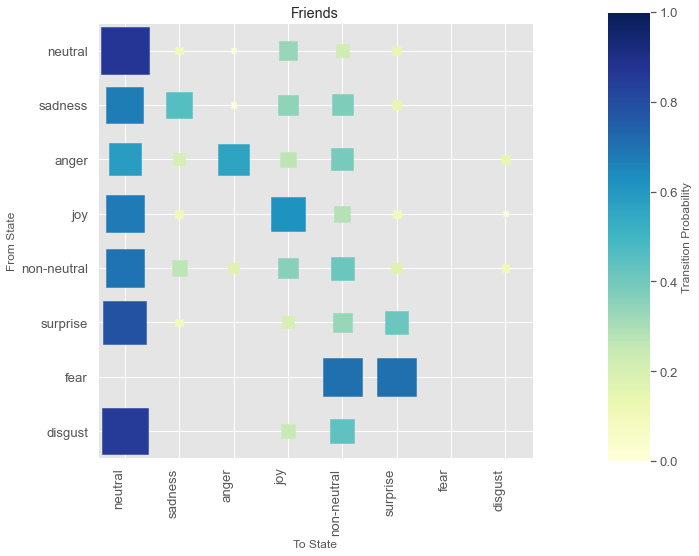

In [36]:
VisualizeTransitionProb(df_test, emo_dict)

# Data Preprocessing Related to Bert Model

Machine Learning models don’t work with text and require data preprocessing to convert text to numbers. As we are using BERT for modelling the word level inputs, we need to do following preprocessing

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called attention mask

We will use the pretrained bert model and tokenizers from the Transformers Library 

# DataLoader Class
As the same utterance can deliver different emotions when it is in different contexts, it is imperative to look at the context of previous utterances in the dialogue while modellign the emotion label. On the other hand, utterances between 2 dialogues are independent of each other. As each dialogue will have different utterlance length. we canot use a constant batch size. 
For this task, We create a class called CustomDataset, and pass the argument Dataset, to allow it to inherit the functionality of the Torch Dataset Class.

In [13]:
'''
  Create the DataLoader Class to provide a way for the dataset code to be decoupled from  model training code.
  Parameters
    ----------
    df : Pandas Dataframe 
        Pandas dataframe repersenting Train/Val/Test Data
    max_number_of_speakers_in_dialogue : Interger 
    emo_dict : Python Dictionary
    Prvides encoded value of emotion labels. 
    encoder : Sklearn OneHot Encoder Handle

  Returns
    -------
  padded : Tensor
     Tensor containing the input data
  attention : Tensor
     Tensor containing attention mask specifying the valid data in input tensor
  spkr_emd : Tensor
     Tensor containing speaker information in the input data
  label : Tensor
     Tensor containing emotion labels
     
'''



class CustomDataset(Dataset):
    def __init__(self, df, max_number_of_speakers_in_dialogue, emo_dict, encoder, args):
        self.data = df
        self.max_number_of_speakers_in_dialogue = max_number_of_speakers_in_dialogue
        self.emo_dict = emo_dict
        self.args = args
        self.encoder = encoder
        if self.args.emoset in ['friends_german', 'emotionpush_german', 'emorynlp_german']:
            if self.args.use_distilbert: 
                print('distilbert-base-german-cased')
                self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-german-cased")
            else :
                print('using dbmdz/bert-base-german-uncased tokenizer')
                self.tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-uncased")
        else:
            print('using distill-uncased tokenizer')
            self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        
        
    def __len__(self):
        if not self.args.emoset == 'semeval':
            return len( self.data['dialogue_id'].unique())
        else:
            return self.data.shape[0]
    
    def get_labels(self, df):
        """
        returns the labels according to the emotion dictionary
        """
        return torch.tensor([self.emo_dict[label] for label in df['label'].values])
    
    '''
        Machine Learning models don’t work with text and require data preprocessing to convert text to numbers. As we are
        using BERT for modelling the word level inputs, we need to do following preprocessing

        - Add special tokens to separate sentences and do classification
        - Pass sequences of constant length (introduce padding)
        - Create array of 0s (pad token) and 1s (real token) called attention mask

        We will use the pretrained bert model and tokenizers from the Transformers Library 
    
    '''
    
    def transform_data(self, df, max_seq_len):
        """
        returns the padded input ids and attention masks according to the DistilBert tokenizer
        """
               
        def tokenize_fct(turn):
            return self.tokenizer.encode(turn, truncation = True, add_special_tokens=True, max_length=max_seq_len)
        
        if self.args.emoset in ['friends', 'emotionpush', 'emorynlp']:
            tokenized = df[['utterance']].applymap(tokenize_fct)
            padded = torch.tensor([[ids + [0]*(max_seq_len-len(ids)) for ids in idx] for idx in tokenized.values])
            attention_mask = torch.where(padded != 0, torch.ones_like(padded), torch.zeros_like(padded))
        elif self.args.emoset == 'semeval':
            tokenized = df[['turn1','turn2','turn3']].applymap(tokenize_fct)
            padded = torch.tensor([[ids + [0]*(max_seq_len-len(ids)) for ids in idx] for idx in tokenized.values])
            attention_mask = torch.where(padded != 0, torch.ones_like(padded), torch.zeros_like(padded))
        elif self.args.emoset in ['friends_german', 'emotionpush_german', 'emorynlp_german']:
            tokenized = df[['utterance_de_deepl']].applymap(tokenize_fct)
            padded = torch.tensor([[ids + [0]*(max_seq_len-len(ids)) for ids in idx] for idx in tokenized.values])
            attention_mask = torch.where(padded != 0, torch.ones_like(padded), torch.zeros_like(padded))
        return padded, attention_mask, tokenized

    
    def __getitem__(self, idx):
        
        if not self.args.emoset == 'semeval':
            assert idx  in list(range (len( self.data['dialogue_id'].unique())))
            df = self.data.loc[self.data.dialogue_id ==idx].reset_index(drop = True)
        else:
            df = self.data.loc[self.data.index ==idx].reset_index(drop = True)  
      
        padded, attention_mask, tokenizer = self.transform_data(df, self.args.max_seq_len)
        labels = self.get_labels(df)
        if not self.args.emoset == 'semeval':
            padded = padded.squeeze(dim=1)
            attention_mask = attention_mask.squeeze(dim=1)
        else:
         
            padded = padded.squeeze(dim=0)
            attention_mask = attention_mask.squeeze(dim=0)
        padded = padded.cuda(self.args.device)
        attention_mask = attention_mask.cuda(self.args.device)
        labels = labels.cuda(self.args.device)
        if self.args.speaker_embedding:
            speakers_array = np.array(df.speaker).reshape(-1, 1)
            spkr_emd = self.encoder.transform(speakers_array).toarray()
                
        else:
            spkr_emd = 0
        
        return padded, attention_mask, spkr_emd, labels
    

# export 
def dataloader(path, max_seq_len, batch_size, emo_dict, use_ddp = False, labels = True):
    """
    Transforms the .csv data stored in `path` according to DistilBert features and returns it as a DataLoader 
    """
    df = open_data(path)
    padded, attention_mask = transform_data(df, max_seq_len)
    
    if labels:
        dataset = TensorDataset(padded, attention_mask, get_labels(df, emo_dict))
    
    else:
        dataset = TensorDataset(padded, attention_mask)
        
    if use_ddp:
        train_sampler = DistributedSampler(dataset)
    
    else: 
        train_sampler = None

    return DataLoader(dataset, batch_size=batch_size, shuffle=(train_sampler is None), 
                      sampler=train_sampler, num_workers=0)


## Transformer Sentence Embeddings

We use a pretrained DistilBert model to create sentence embeddings for each utterance. We obtain contextual word embeddings by concatenating the CLS token embedding and the mean of the last layer. 

For more information on the (Distil)Bert models one can look at 
Jay Alammar's blog posts ([A Visual Guide to Using BERT for the First Time](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) and [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)) where also the following illustration is taken from.

![DistilBert output](./images/bert-distilbert-output-tensor-predictions.png)

Further references:
 
* [DistilBert paper](https://arxiv.org/abs/1910.01108) and [blog post](https://medium.com/huggingface/distilbert-8cf3380435b5)
* [Original Bert (Bidirectional Encoder Representations from Transformers) paper](https://arxiv.org/abs/1810.04805)
* [tutorial for custom PyTorch modules](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
* [Huggingface transformers documentation](https://huggingface.co/transformers/v2.3.0/index.html)

In [14]:
'''
  This class makes use of DistilBert model to model word level input and capture the context of utterance level embeddings.
  It makes use of pretrained language model which is equivalent to introducing external data into the model and helps our
  model obtain better utterance embedding
  Parameters
    ----------
    args: Structure of various flags used in the code. 
    droput : Dropout  
  
  Returns
    -------
  sentence_embeds : Tensor
     Tensor containing the utterance level embeddings.
     
'''


class sentence_embeds_model(torch.nn.Module):
    """
    instantiates the pretrained DistilBert model and the linear layer
    """
    
    def __init__(self, args, dropout = 0.1):
        super(sentence_embeds_model, self).__init__()
        self.args = args
        
        if self.args.emoset in ['friends_german', 'emotionpush_german', 'emorynlp_german']:
            if args.use_distilbert:
                self.transformer = DistilBertModel.from_pretrained('distilbert-base-german-cased', dropout=dropout, 
                                                           output_hidden_states=True)
            else:
                self.transformer = AutoModel.from_pretrained("dbmdz/bert-base-german-uncased", output_hidden_states=True)
                                                           
        else:
            self.transformer = DistilBertModel.from_pretrained('distilbert-base-uncased', dropout=dropout, 
                                                           output_hidden_states=True)
        self.embedding_size = 2 * self.transformer.config.hidden_size
      
      
        
    def layerwise_lr(self, lr, decay):
        """
        returns grouped model parameters with layer-wise decaying learning rate
        """
        bert = self.transformer
        
        if self.args.emoset in ['friends_german', 'emotionpush_german', 'emorynlp_german'] and not self.args.use_distilbert:
            num_layers = bert.config.num_hidden_layers
            opt_parameters = [{'params': bert.embeddings.parameters(), 'lr': lr*decay**num_layers}]
            opt_parameters += [{'params': bert.encoder.layer[l].parameters(), 'lr': lr*decay**(num_layers-l+1)} 
                            for l in range(num_layers)]
        else:
            num_layers = bert.config.n_layers
            opt_parameters = [{'params': bert.embeddings.parameters(), 'lr': lr*decay**num_layers}]
            opt_parameters += [{'params': bert.transformer.layer[l].parameters(), 'lr': lr*decay**(num_layers-l+1)} 
                            for l in range(num_layers)]
     
        return opt_parameters
               
    def forward(self, input_ids = None, attention_mask = None, input_embeds = None):
        """
        returns the sentence embeddings
        """
        utterance_count = input_ids.shape[1]
        
        if input_ids is not None:
            input_ids = input_ids.flatten(end_dim = 1)
     
        if attention_mask is not None:
            attention_mask = attention_mask.flatten(end_dim = 1)
        
       
       
        output = self.transformer(input_ids = input_ids, 
                                  attention_mask = attention_mask, inputs_embeds = input_embeds)
      
        cls = output[0][:,0]
        if self.args.emoset in ['friends_german', 'emotionpush_german', 'emorynlp_german'] and not self.args.use_distilbert:
            hidden_mean = torch.mean(output[2][-1],1)
        else:
            hidden_mean = torch.mean(output[1][-1],1)
        sentence_embeds = torch.cat([cls, hidden_mean], dim = -1)
        sentence_embeds = sentence_embeds.view(-1,utterance_count, self.embedding_size)
       
        return sentence_embeds

## Context Transformer and Classification

We use another transformer model to create contextual sentence embeddings, i.e. we model that a conversation consists of multiple utterances. Moreover, we add a classification model for the emotion of the last utterance.
Note that for our convenience we use

* a linear projection of the sentence embeddings to a given `projection_size`
* a (not pre-trained) DistilBertForSequenceClassification and flip the order of the utterances as the first input embedding gets classified by default
* only one attention head, see also the paper [Are Sixteen Heads Really Better than One?](https://arxiv.org/abs/1905.10650).

In [15]:
'''
  Create contextual sentence embeddings- We model that a conversation may consists of vatiable number of utterances for 
  dataset Friends/EmotionPush/EmoryNLP whereas for semeval number of utterances per conversation is fixed to 3. 
    ----------
    embedding_size: Embedded Layer Size
    projection_size :Size of fully connected lazer before the bert model. 
    n_layers : Number of hidden layers in pretrained bert model 
    emo_dict : Label Encoding
    max_number_of_speakers_in_dialogue
    max_number_of_utter_in_dialogue : 25 for Friends/EmotionPush/EmoryNLP and 3 for Semeval. 
    loss_weights : Tensor containing the weight assigned to different label classes to handle class imblance. 
  Returns
    -------
  logits : Tensor
     Softmax Probability Distribution

  loss : Scalor
      
'''
class context_classifier_model(torch.nn.Module):
    """
    instantiates the DisitlBertForSequenceClassification model, the position embeddings of the utterances, 
    and the binary loss function
    """
    
    def __init__(self, 
                 embedding_size, 
                 projection_size, 
                 n_layers, 
                 emo_dict, 
                 focus_dict, 
                 max_number_of_speakers_in_dialogue, 
                 max_number_of_utter_in_dialogue,
                 args,
                 loss_weights,
                 dropout = 0.1):
        super(context_classifier_model, self).__init__()
     
        self.projection_size = projection_size
        self.projection = torch.nn.Linear(embedding_size, projection_size)  
        self.max_number_of_speakers_in_dialogue = max_number_of_speakers_in_dialogue
        self.max_number_of_utter_in_dialogue = max_number_of_utter_in_dialogue
        self.position_embeds = torch.nn.Embedding( self.max_number_of_utter_in_dialogue, projection_size)
     
        self.norm = torch.nn.LayerNorm(projection_size+self.max_number_of_speakers_in_dialogue)
        self.drop = torch.nn.Dropout(dropout)
        self.focus_dict = focus_dict
        self.emo_dict = emo_dict
        self.args = args
        self.loss_weights = loss_weights
        context_config = DistilBertConfig(dropout=dropout, 
                                dim=projection_size+self.max_number_of_speakers_in_dialogue,
                                hidden_dim=4*projection_size,
                                n_layers=n_layers,
                                n_heads = 1,
                                num_labels=len(self.emo_dict.keys()))
      
        self.context_transformer = DistilBertForSequenceClassification(context_config)
    
        if not self.args.emoset == 'semeval':
            self.others_label = self.emo_dict['neutral']
        else:
            self.others_label = self.emo_dict['others']
        self.bin_loss_fct = torch.nn.BCEWithLogitsLoss()
        self.context_experiment_flag = False
   
        
    def bin_loss(self, logits, labels):
        """
        defined the additional binary loss for the `others` label
        """
        bin_labels = torch.where(labels == self.others_label, torch.ones_like(labels), 
                                 torch.zeros_like(labels)).float()
        bin_logits = logits[:, self.others_label]    
        return self.bin_loss_fct(bin_logits, bin_labels)

    
    
    def comput_loss(self, log_prob, target, weights):
        """ Weighted loss function """
        #loss = F.nll_loss(log_prob, target, weight=weights, reduction='sum')
        loss = F.cross_entropy(log_prob, target, weight=weights, reduction='sum')
        loss /= target.size(0)

        return loss


    def forward(self, sentence_embeds, spkr_emd, labels = None):
        """
        returns the logits and the corresponding loss if `labels` are given
        """
        if self.context_experiment_flag == True:
            sentence_embeds = sentence_embeds.transpose(0, 1)
            spkr_emd = spkr_emd.transpose(0,1)
            position_ids = torch.arange(sentence_embeds.shape[1], dtype=torch.long, device=sentence_embeds.device)
            
        else:
            position_ids = torch.arange(sentence_embeds.shape[1], dtype=torch.long, device=sentence_embeds.device)
    
        position_ids = position_ids.expand(sentence_embeds.shape[:2]) 
        position_embeds = self.position_embeds(position_ids)
        sentence_embeds = self.projection(sentence_embeds) + position_embeds 
        if self.args.speaker_embedding:
            sentence_embeds = torch.cat((sentence_embeds, spkr_emd), dim=2)
            sentence_embeds = sentence_embeds.to(device=self.args.device, dtype=torch.float)
        sentence_embeds = self.drop(self.norm(sentence_embeds))
        if labels is None:
            if not self.emoset == 'semeval':
                return self.context_transformer(inputs_embeds = sentence_embeds.transpose(0, 1), labels = labels)[0]
            else:
                return self.context_transformer(inputs_embeds = sentence_embeds.flip(1), labels = labels)[0]
        else:
            if not self.args.emoset == 'semeval':
                output =  self.context_transformer(inputs_embeds = sentence_embeds.transpose(0, 1), labels = labels)
            else:
                output =  self.context_transformer(inputs_embeds = sentence_embeds.flip(1), labels = labels)
        loss = output[0]
        logits = output[1]
        log_prob = logits
        if not self.args.emoset == 'semeval':
            loss2 = self.comput_loss(log_prob, labels, self.loss_weights)
            return loss2, logits
        else:
            return loss + self.bin_loss(logits, labels), logits
        

# Plotting Functions
- This section consists of various plotting function used for the result analysis

In [16]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        j = 0
        group_percentages = []
        for i in range(len(cf.flatten())):
            if i% cf.shape[0]== 0:
                divisor = sum(cf[j, :])
                j = j+1
            group_percentages.append("{0:.2%}".format(cf.flatten()[i]/divisor) )
        #group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    print( box_labels)
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        print('Calculating sum stats')
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""
    print(stats_text)

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    chart = sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories, annot_kws={"size": 13})
    #chart = sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,yticklabels=categories)
    chart.set_xticklabels(categories,  fontsize=15)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text, fontsize = 15)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        
def plot_per_Class_f1_score(args, focus_dict, score):
    plt.figure(figsize=(6,6))
    if args.emoset == 'emorynlp' or args.emoset == 'emorynlp_german':
        plt.xticks(fontsize=13, rotation=90)
    else:
        plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Macro-F1 Score')
    plt.xlabel('Emotion Class', fontsize = 15)
    width = [0.6]*len(focus_dict)
    if args.emoset == 'friends' or args.emoset == 'friends_german':
        plt.title('Friends', fontsize=16)
    elif args.emoset == 'emotionpush' or args.emoset == 'friends_emotionpush':
        plt.title('EmotionPush', fontsize=16)
    elif args.emoset == 'emorynlp' or args.emoset == 'emorynlp_german':
        plt.title('EmoryNLP', fontsize=16)
    elif args.emoset == 'semeval':
        plt.title('Semeval', fontsize=16)
        plt.ylabel('Micro-F1 Score')
        width = [0.45]*len(focus_dict)
        
        

    plt.bar(focus_dict, list(score[0]['microF1_per_class'].values()),  hatch='///',  fill=True, width = width )
    

def plot_F1_Score_against_speaker_count(df, model):
    speakers_count_dict  = {}
    macroF1_list = []
    dialogue_id_list = list((df['dialogue_id'].unique()))

    for dialogue in dialogue_id_list:
        df_dialogue = df[(df.dialogue_id ==dialogue)]
        speaker_count = len(df_dialogue.speaker.unique())
        if speaker_count not in speakers_count_dict.keys():
            speakers_count_dict[speaker_count] = []
        for i in range(df_dialogue.shape[0]):
            speakers_count_dict[speaker_count].append(df_dialogue.index[i])
            
    for i in sorted(speakers_count_dict.keys()):
        y_pred = [model.y_pred[j] for j in speakers_count_dict[i]]
        y_true = [model.y_true[j] for j in speakers_count_dict[i]]
        (macroF1, microF1) = calc_f1_score_1(y_pred, y_true,model.emo_dict, model.focus_emo)
        macroF1_list.append(macroF1)   
    
    plt.figure(figsize=(8,6))
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Macro-F1 Score')
    plt.xlabel('The number of speakers')
    width = [0.6]*len(speakers_count_dict.keys())
    if args.emoset == 'friends' or args.emoset == 'friends_german':
          plt.title('Friends', fontsize=16)
    elif args.emoset == 'emotionpush' or args.emoset == 'friends_emotionpush':
         plt.title('EmotionPush', fontsize=16)
    elif args.emoset == 'emorynlp' or args.emoset == 'emorynlp_german':
          plt.title('EmoryNLP', fontsize=16)
    speaker_count_list = [str(l) for l in sorted(speakers_count_dict.keys())]
    plt.bar(speaker_count_list, macroF1_list,  hatch='///',  fill=True, width = width )
    plt.show()
    
def plot_F1_Score_against_dialogue_length(df, model):
    utterance_count_dict  = {}
    macroF1_list = []
    dialogue_id_list = list((df['dialogue_id'].unique()))

    for dialogue in dialogue_id_list:
        df_dialogue = df[(df.dialogue_id ==dialogue)]
        utteranc_count = df_dialogue.shape[0]
        if utteranc_count <= 5:
            key_position = 1
        elif utteranc_count <= 10:
            key_position = 2
        elif utteranc_count <= 15:
            key_position = 3
        elif utteranc_count <= 20:
            key_position = 4
        elif utteranc_count <= 25:
            key_position = 5
        elif utteranc_count > 25:
            key_position = 6

        if key_position not in utterance_count_dict.keys():
                utterance_count_dict[key_position] = []
        for i in range(df_dialogue.shape[0]):
            utterance_count_dict[key_position].append(df_dialogue.index[i])
    
    
    for i in sorted(utterance_count_dict.keys()):
        y_pred = [model.y_pred[j] for j in utterance_count_dict[i]]
        y_true = [model.y_true[j] for j in utterance_count_dict[i]]
        (macroF1, microF1) = calc_f1_score_1(y_pred, y_true,model.emo_dict, model.focus_emo)
        macroF1_list.append(macroF1)    


    plt.figure(figsize=(6,6))
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Macro-F1 Score')
    plt.xlabel('The number of utterances')
    width = [0.6]*len(utterance_count_dict.keys())
    if args.emoset == 'friends' or args.emoset == 'friends_german':
          plt.title('Friends', fontsize=16)
    elif args.emoset == 'emotionpush' or args.emoset == 'friends_emotionpush':
         plt.title('EmotionPush', fontsize=16)
    elif args.emoset == 'emorynlp' or args.emoset == 'emorynlp_german':
          plt.title('EmoryNLP', fontsize=16)

    plt.bar(['1-5', '6-10', '11-15', '16-20', '21-25'], macroF1_list,  hatch='///',  fill=True, width = width )

def plot_F1_Score_against_utterance_length(df, model):
    dialog_length_threshold = 20
    utterance_position_dict  = {}
    macroF1_list = []
    
    for i in range(dialog_length_threshold):
        utterance_position_dict[i] = []
    dialogue_id_list = list((df['dialogue_id'].unique()))
    
    for dialogue in dialogue_id_list:
        df_dialogue = df[(df.dialogue_id ==dialogue)]
        for i in range(df_dialogue.shape[0]):
            if i >= dialog_length_threshold:
                break
            utterance_position_dict[i].append(df_dialogue.index[i])

    for i in utterance_position_dict.keys():
        y_pred = [model.y_pred[j] for j in utterance_position_dict[i]]
        y_true = [model.y_true[j] for j in utterance_position_dict[i]]
        (macroF1, microF1) = calc_f1_score_1(y_pred, y_true,model.emo_dict, model.focus_emo)
        macroF1_list.append(macroF1)    

    plt.figure(figsize=(8,6))
    x_ticks = np.arange(0, 25, 5)
    plt.xticks(x_ticks)
    plt.plot(utterance_position_dict.keys(), macroF1_list,  linewidth=3)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Macro-F1 Score')
    plt.xlabel('Utterance Position in the Dialogue', fontsize = 15)
    if args.emoset == 'friends' or args.emoset == 'friends_german':
          plt.title('Friends', fontsize=16)
    elif args.emoset == 'emotionpush' or args.emoset == 'friends_emotionpush':
         plt.title('EmotionPush', fontsize=16)
    elif args.emoset == 'emorynlp' or args.emoset == 'emorynlp_german':
          plt.title('EmotionPush', fontsize=16)
    plt.xlim([0, 20])
    plt.show()



# Metrices

- Semeval Task 3 : We use the metrics, i.e. microaveraged precision, recall, and f1-score (while ignoring the others class), for the evaluation of our model according to the [SemEval-2019 Task 3 challenge](https://www.aclweb.org/anthology/S19-2005/). 

- Friends/EmoryPush/EmoryNLP : we choose the macro averaged Recall as the primary metric for evaluating the performance of our models.

In [17]:
'''
    Create True Positive, False Negative and False Positive metrices. 
    ----------
    loss: Scalor Loss
    logits :Softmax Probablity Distribution
    labels : groundtrugh emotion labels
    emo_dict : Label Encoding dictionary
    focus_emo : List holding the primary emotion labels. 
    -------
    Return : Python Dictionarx containing various loss metrices
      
'''

def metrics(loss, logits, labels, emo_dict,focus_emo, args):
    
    labelslist = labels.cpu().tolist()
    preds = torch.argmax(logits, dim=1)
    predslist = preds.cpu().tolist() 
  
    cm = np.zeros((len(emo_dict.keys()),len(emo_dict.keys())), dtype=np.int64) # recall
       
  
    for label, pred in zip(labels.view(-1), preds.view(-1)):
        cm[label.long(), pred.long()] += 1
   
    if not args.emoset == 'semeval':
        cm = cm[0:len(focus_emo), 0:len(focus_emo)]
        gt_labels_per_class =  cm.sum(axis = 1)
        preds_per_class =  cm.sum(axis = 0)
        tp = cm.diagonal()[0:]
        fp = preds_per_class-tp
        fn = gt_labels_per_class- tp
    else:
        gt_labels_per_class =  cm[1:, :].sum(axis = 1)
        preds_per_class =  cm[:, 1:].sum(axis = 0)
        tp = cm.diagonal()[1:]
        fp = preds_per_class-tp
        fn = gt_labels_per_class- tp
   
    return {'val_loss': loss, 
            'tp': tp, 
            'fp': fp, 
            'fn': fn, 
            'preds':preds_per_class,
            'labels': gt_labels_per_class ,
            'y_pred':predslist,
            'y_true':labelslist
            }

'''
    Calculates Macro/Micro Precision/Recall/F1-Score
    ----------
        
'''
def calc_f1_score(tp, fp, fn):
    prec_rec_f1 = {}
    tp_fn = tp+fn
    tp_fp = tp+fp


    Recall = [np.round(tp/tp_fn*100, 2) if tp_fn>0 else 0.0 for tp,tp_fn in zip(tp,tp_fn)]
    prec_rec_f1['microRecall'] = np.round((sum(tp)/ sum(tp_fn))*100, 2)
    prec_rec_f1['macroRecall'] = np.round (sum(Recall) / len(Recall),2)
    
    Precision = [np.round(tp/tp_fp*100, 2) if tp_fp>0 else 0.0 for tp,tp_fp in zip(tp,tp_fp)]
    prec_rec_f1['microPrecision'] = np.round((sum(tp)/ sum(tp_fp))*100, 2)
    prec_rec_f1['macroPrecision'] = np.round(sum(Precision) / len(Precision),2)
    
    per_class_f1score = []
    f1_numenator = [2*x*y for (x, y) in zip(Recall, Precision)]
    f1_denominator = [x + y for (x, y) in zip(Recall, Precision)]

    for num1, num2 in zip(f1_numenator,f1_denominator):
        if  num2:
            per_class_f1score.append(np.round(num1 / num2, 2))
        else:
            per_class_f1score.append(0.0)
    
    macroPrecision = prec_rec_f1['macroPrecision']
    macroRecall = prec_rec_f1['macroRecall']
    macroF1 = (2 * macroRecall * macroPrecision ) / (macroPrecision + macroRecall) if (macroPrecision+macroRecall) > 0 else 0
    prec_rec_f1['microF1_score'] = 2 * (prec_rec_f1['microPrecision'] * prec_rec_f1['microRecall']) / (prec_rec_f1['microPrecision'] + prec_rec_f1['microRecall'])
    prec_rec_f1['macroF1_score'] = np.round(macroF1, 2)
    
   
    prec_rec_f1['macroF1_per_class'] = per_class_f1score
    return prec_rec_f1


'''
    Calculates Macro/Micro Precision/Recall/F1-Score from y_true, y_pred
    ----------
        
'''
def calc_f1_score_1(y_pred, y_true,emo_dict, focus_emo):
    cm = np.zeros((len(emo_dict.keys()),len(emo_dict.keys())), dtype=np.int64) # recall


    for label, pred in zip(y_true, y_pred):
        cm[label, pred] += 1

    cm = cm[0:len(focus_emo), 0:len(focus_emo)]
    gt_labels_per_class =  cm.sum(axis = 1)
    preds_per_class =  cm.sum(axis = 0)
    tp = cm.diagonal()[0:]
    fp = preds_per_class-tp
    fn = gt_labels_per_class- tp

    tp_fn = tp+fn
    tp_fp = tp+fp

    Recall = [np.round(tp/tp_fn*100, 2) if tp_fn>0 else 0.0 for tp,tp_fn in zip(tp,tp_fn)]
    microRecall  = np.round((sum(tp)/ sum(tp_fn))*100, 2)
    macroRecall = np.round (sum(Recall) / len(Recall),2)

    Precision = [np.round(tp/tp_fp*100, 2) if tp_fp>0 else 0.0 for tp,tp_fp in zip(tp,tp_fp)]
    microPrecision = np.round((sum(tp)/ sum(tp_fp))*100, 2)
    macroPrecision = np.round(sum(Precision) / len(Precision),2)

    macroF1 = (2 * macroRecall * macroPrecision ) / (macroPrecision + macroRecall) if (macroPrecision+macroRecall) > 0 else 0
    microF1 = (2 * microRecall * microPrecision ) / (microPrecision + microRecall) if (microPrecision+microRecall) > 0 else 0
    macroF1 = np.round(macroF1, 2)
    microF1 = np.round(microF1, 2)
    return macroF1, microF1






# PyTorch Lightning

> We use pytorch lighting framework for the Training/Evaluation Loop Implementation

In [18]:
class EmotionModel(pl.LightningModule):
    """
    PyTorch Lightning module for the Contextual Emotion Detection in Text Challenge
    """

    def __init__(self, emo_dict, focus_dict, args, df_train, df_val, df_test, verbosity = 1):
        """
        pass in parsed HyperOptArgumentParser to the model
        """
        super(EmotionModel, self).__init__()

        self.model_name = 'Semeval'
        self.emo_dict = emo_dict
        self.focus_dict = focus_dict
        self.focus_emo = [emo_dict[w] for w in focus_dict]
        self.max_seq_len = args.max_seq_len
        self.dropout = args.dropout
        self.projection_size = args.projection_size
        self.args = args
        self.n_layers = args.n_layers
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test
        self.verbosity = verbosity
        if args.speaker_embedding:
            print('Speaker Embedding is Enabled')
            self.encoder, self.max_number_of_speakers_in_dialogue = self.get_speakers_encoder_with_complete_speakers_list()
            print('Max number of speakers in a dialgue = {}'.format(self.max_number_of_speakers_in_dialogue))
        else:
            print('Speaker Embedding is Disabled')
            self.max_number_of_speakers_in_dialogue =0
            self.encoder = 0
            
        if not self.args.emoset == 'semeval':
            self.max_number_of_utter_in_dialogue = self.get_max_utterance_length_in_dialogue()
        else:
            self.max_number_of_utter_in_dialogue = 3
        
        #Need to explore this hyperparameter
        self.weight_rate =1
        self.loss_weights = self.calc_loss_weight(self.df_train, self.weight_rate )
        self.loss_weights = self.loss_weights.cuda(self.args.device)
        print( 'loss weights = {}'.format(self.loss_weights))
        self.class_weights = self.calc_class_weight(self.df_train, self.weight_rate )
        self.class_weights = self.class_weights.cuda(self.args.device)
        print( 'class weights = {}'.format(self.class_weights))
        self.sentence_embeds_model = sentence_embeds_model(self.args, dropout = self.dropout)
        self.context_classifier_model = context_classifier_model(self.sentence_embeds_model.embedding_size,
                                                                 self.projection_size, 
                                                                 self.n_layers, 
                                                                 self.emo_dict, 
                                                                 self.focus_dict,
                                                                 self.max_number_of_speakers_in_dialogue,
                                                                 self.max_number_of_utter_in_dialogue,
                                                                 self.args,
                                                                 self.loss_weights,
                                                                 dropout = self.dropout)
        self.sentence_embeds_model.cuda(self.args.device)
        self.context_classifier_model.cuda(self.args.device)
    
    def calc_loss_weight(self, df, rate=1.0):
        """ Loss weights """
        emo_count = {}
        for emo in self.emo_dict.keys():
            emo_count[emo] =df['label'].value_counts()[emo]
        min_emo = float(min([ emo_count[w] for w in self.focus_dict]))
        if self.args.balance_weight_warming:
            weight = [math.pow(min_emo / emo_count[k], rate) if k in self.focus_dict else 0 for k,v in emo_count.items()]
        else:
            weight = [math.pow(1, rate) if k in self.focus_dict else 0 for k,v in emo_count.items()]
        weight = np.array(weight)
        weight /= np.sum(weight)
        weight = torch.from_numpy(weight).float()
        return weight
    
    def calc_class_weight(self, df, rate=1.0):
        """ class weights """
        emo_count = {}
        for emo in self.emo_dict.keys():
            if emo in self.focus_dict:
                emo_count[emo] =df['label'].value_counts()[emo]
            
        
        weight = [(v / sum(emo_count.values())) for k,v in emo_count.items()]
        weight = np.array(weight)
        weight = torch.from_numpy(weight).float()
        return weight
    
    
    def get_speakers_encoder_with_complete_speakers_list(self):
        speaker_list = list(self.df_train.speaker)
        speaker_list.extend(list(self.df_val.speaker))
        speaker_list.extend(list(self.df_test.speaker))
        speaker_set = set(speaker_list )
        speaker_list = []
        for e in speaker_set:
            templist = []
            templist.append(e)
            speaker_list.append(templist)
        cat = OneHotEncoder()
        cat.fit(np.asarray(speaker_list, dtype = object))
        return cat, len(speaker_set)
 
    def get_speakers_encoder_with_only_main_speakers_list(self):
        
        speaker_list = []
        complete_speaker_list = list(self.df_train['speaker'])
        complete_speaker_list.extend(list(self.df_val['speaker']))
        complete_speaker_list.extend(list(self.df_test['speaker']))
        occurence_count = Counter(complete_speaker_list)
        common_speakers = occurence_count.most_common(6)
        for e in common_speakers:
            templist = []
            templist.append(e[0])
            speaker_list.append(templist)
        speaker_list.append(['Unknown'])
        cat = OneHotEncoder()
        cat.fit(np.asarray(speaker_list, dtype = object))
        return cat, len(cat.categories_[0].tolist())

    def get_max_number_of_speakers_in_dialogue(self):
        number_of_speakers_in_dialogue = []
        train_dialogue_id_list = list((self.df_train['dialogue_id'].unique()))
        val_dialogue_id_list = list((self.df_val['dialogue_id'].unique()))
        test_dialogue_id_list = list((self.df_test['dialogue_id'].unique()))
        
        for dialogue in train_dialogue_id_list:
            number_of_speakers_in_dialogue.append(len(set(self.df_train[(self.df_train.dialogue_id ==dialogue)].speaker)))
        for dialogue in val_dialogue_id_list:
            number_of_speakers_in_dialogue.append(len(set(self.df_val[(self.df_val.dialogue_id ==dialogue)].speaker)))
        for dialogue in test_dialogue_id_list:
            number_of_speakers_in_dialogue.append(len(set(self.df_test[(self.df_test.dialogue_id ==dialogue)].speaker)))
        return( max(number_of_speakers_in_dialogue))
    
    def get_max_utterance_length_in_dialogue(self):
        #import IPython; IPython.embed();  exit(1)
        train_dialogue_id_list = list((self.df_train['dialogue_id'].unique()))
        val_dialogue_id_list = list((self.df_val['dialogue_id'].unique()))
        test_dialogue_id_list = list((self.df_test['dialogue_id'].unique()))
        number_of_utterance_in_dialogue = []
        for dialogue in train_dialogue_id_list:
             number_of_utterance_in_dialogue.append((self.df_train.dialogue_id ==dialogue).sum())
        for dialogue in val_dialogue_id_list:
             number_of_utterance_in_dialogue.append((self.df_val.dialogue_id ==dialogue).sum())
        for dialogue in test_dialogue_id_list:
             number_of_utterance_in_dialogue.append((self.df_test.dialogue_id ==dialogue).sum())
        return( max(number_of_utterance_in_dialogue))
       

    def forward(self, input_ids, attention_mask, spkr_emd, labels = None):
        """
        no special modification required for lightning, define as you normally would
        """
      
        sentence_embeds = self.sentence_embeds_model(input_ids = input_ids, 
                                                             attention_mask = attention_mask)
    
        return self.context_classifier_model(sentence_embeds = sentence_embeds,spkr_emd = spkr_emd, labels = labels)
    
    def training_step(self, batch, batch_idx):
        """
        Lightning calls this inside the training loop
        """       
        input_ids, attention_mask, spkr_emd , labels = batch
        spkr_emd = spkr_emd.cuda(self.args.device)
        labels = labels.view(-1)
              
        loss, _ = self.forward(input_ids = input_ids, attention_mask = attention_mask, spkr_emd = spkr_emd, labels = labels)
       
        tensorboard_logs = {'train_loss': loss}
        self.log('train_loss', loss, prog_bar=True)
        return {'loss': loss, 'log': tensorboard_logs}

    
    def validation_step(self, batch, batch_idx):
        """
        Lightning calls this inside the validation loop
        """
        
        input_ids, attention_mask, spkr_emd , labels = batch
        spkr_emd = spkr_emd.cuda(self.args.device)
        labels = labels.view(-1)
        
        loss, logits = self.forward(input_ids = input_ids, attention_mask = attention_mask,spkr_emd = spkr_emd,  labels = labels)
        scores_dict = metrics(loss, logits, labels, self.emo_dict,self.focus_emo, self.args)
        return scores_dict
    
    def validation_epoch_end(self, outputs):
        """
        called at the end of validation to aggregate outputs
        :param outputs: list of individual outputs of each validation step
        :return:
        """
        #import IPython; IPython.embed();  exit(1)
        tqdm_dict = {}
        
        tqdm_dict['val_loss'] = 0
        tqdm_dict['preds'] = [0 for w in self.focus_dict]
        tqdm_dict['labels'] = [0 for w in self.focus_dict]
        tqdm_dict['tp'] = [0 for w in self.focus_dict]
        tqdm_dict['fp'] = [0 for w in self.focus_dict]
        tqdm_dict['fn'] = [0 for w in self.focus_dict]
        tqdm_dict['acc_per_class'] = [0 for w in self.focus_dict]
        tqdm_dict['y_pred'] = []
        tqdm_dict['y_true'] = []
        
        for metric_name in outputs[0].keys():
          
            for output in outputs:
                metric_value = output[metric_name]
                if metric_name in ['y_pred', 'y_true']:
                    tqdm_dict[metric_name].extend(metric_value)
                else:
                    tqdm_dict[metric_name] += metric_value
                    
            if metric_name in ['val_loss']:
                tqdm_dict[metric_name] =  tqdm_dict[metric_name] / len(outputs)
                
               
        for i in range(len(self.focus_dict)):
            if  tqdm_dict['labels'][i]:
                tqdm_dict['acc_per_class'][i] = np.round((tqdm_dict['tp'][i] / tqdm_dict['labels'][i])*100, 2)
            else:
                tqdm_dict['acc_per_class'][i] = 0.0
        
        
        tqdm_dict['acc_unweighted'] = np.round(sum(tqdm_dict['acc_per_class']) / len(tqdm_dict['acc_per_class']),2)       
        tqdm_dict['acc_weighted'] = sum(weight * value for weight, value in zip(self.class_weights, tqdm_dict['acc_per_class']))
        
        tqdm_dict['acc_weighted'] = (tqdm_dict['acc_weighted'] * 10**2).round() / (10**2)
        prec_rec_f1 = calc_f1_score(tqdm_dict['tp'], tqdm_dict['fp'], tqdm_dict['fn'])
        tqdm_dict.update(prec_rec_f1) 
        self.y_true = tqdm_dict.pop("y_true", None)
        self.y_pred = tqdm_dict.pop("y_pred", None)
        
        microF1_per_class = {}
        for emotion_class in range(len(tqdm_dict["macroF1_per_class"])):
            microF1_per_class[str(emotion_class)] = tqdm_dict["macroF1_per_class"][emotion_class]
      
        self.log('valid_loss', tqdm_dict["val_loss"], prog_bar=False)
        self.log('valid_ac_unweighted', tqdm_dict["acc_unweighted"], prog_bar=False)
        self.log('macroF1', tqdm_dict["macroF1_score"], prog_bar=False)
        self.log('microF1', tqdm_dict["microF1_score"], prog_bar=False)
        self.log('microF1_per_class', microF1_per_class, prog_bar=False)
        
        
        if self.verbosity :
            print(*tqdm_dict.items(), sep='\n')
        result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': tqdm_dict["val_loss"] }
        
        return result

    
    def test_step(self, batch, batch_idx):
 
        return self.validation_step(batch, batch_idx)

    
    def test_epoch_end(self, outputs):
        return_value =  self.validation_epoch_end(outputs)
        return (return_value)
    
    def configure_optimizers(self):
        """
        returns the optimizer and scheduler
        """
        params = self.sentence_embeds_model.layerwise_lr(self.args.lr, self.args.layerwise_decay)
        params += [{'params': self.context_classifier_model.parameters()}]
        self.optimizer = torch.optim.Adam(params, lr=self.args.lr)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10)
        return [self.optimizer], [self.scheduler]
    

   
    def train_dataloader(self):
        
        dataset = CustomDataset(self.df_train, self.max_number_of_speakers_in_dialogue, self.emo_dict, self.encoder, self.args)
        train_loader = DataLoader(dataset, self.args.batch_size, shuffle=True, num_workers=0)
      
        return train_loader

    

    def val_dataloader(self):

        dataset = CustomDataset(self.df_val, self.max_number_of_speakers_in_dialogue, self.emo_dict, self.encoder, self.args)
        val_loader = DataLoader(dataset, self.args.batch_size, shuffle=False, num_workers=0)
      
        return val_loader

    def test_dataloader(self):
        
        dataset = CustomDataset(self.df_test, self.max_number_of_speakers_in_dialogue, self.emo_dict, self.encoder, self.args)
        test_loader = DataLoader(dataset, self.args.batch_size, shuffle=False, num_workers=0)
       
        return test_loader     

def train_model (model):
    
    early_stop_callback = pl.callbacks.EarlyStopping(monitor='valid_loss', min_delta=0.0005, patience=5,
                                        verbose=True, mode='min')
   
    if model.args.emoset == 'emotionpush' or model.args.emoset == 'emotionpush_german' :
        checkpoint_callback = pl.callbacks.ModelCheckpoint( monitor='macroF1' , mode = 'max', save_top_k = model.args.epochs) 
    else:
        checkpoint_callback = pl.callbacks.ModelCheckpoint( monitor='valid_loss' , mode = 'min', save_top_k = model.args.epochs)
  
    gpu_list = [int(model.args.gpu)]  
    trainer = pl.Trainer(default_root_dir=os.getcwd(),
                    gpus=(gpu_list if torch.cuda.is_available() else 0),
                    max_epochs= model.args.epochs,
                    fast_dev_run=False,
                    deterministic=True,
                    callbacks = [early_stop_callback,checkpoint_callback] 
                    )
    trainer.fit(model)
    return trainer
    
def test_model(trainer, model):
    if 1:
        print('In Test Model')
        score = trainer.test(verbose = model.verbosity)
    else:
        checkpoint_path = './lightning_logs/version_0/checkpoints/'
        checkpoints = os.listdir(checkpoint_path)

        for checkpoint in checkpoints:
            print(checkpoint)
            score = trainer.test(ckpt_path = checkpoint_path + checkpoint )
    return score 

# Create Model

In [19]:
model = EmotionModel(emo_dict, focus_dict, args, df_train, df_val, df_test, verbosity = True)
model = model.cuda(args.device)
model

Speaker Embedding is Enabled
Max number of speakers in a dialgue = 364
loss weights = tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
class weights = tensor([0.7844, 0.0427, 0.0103, 0.1626], device='cuda:0')
In function DistilBertForSequenceClassification


EmotionModel(
  (sentence_embeds_model): sentence_embeds_model(
    (transformer): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn):

In [48]:
trainer = train_model(model)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type                     | Params
----------------------------------------------------------------------
0 | sentence_embeds_model    | sentence_embeds_model    | 66.4 M
1 | context_classifier_model | context_classifier_model | 86.0 M
----------------------------------------------------------------------
152 M     Trainable params
0         Non-trainable params
152 M     Total params
609.457   Total estimated model params size (MB)


using distill-uncased tokenizer


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42


('val_loss', tensor(0.4825, device='cuda:0'))
('preds', array([2, 3, 1, 5], dtype=int64))
('labels', array([9, 1, 0, 1], dtype=int64))
('tp', array([2, 1, 0, 1], dtype=int64))
('fp', array([0, 2, 1, 4], dtype=int64))
('fn', array([7, 0, 0, 0], dtype=int64))
('acc_per_class', [22.22, 100.0, 0.0, 100.0])
('acc_unweighted', 55.56)
('acc_weighted', tensor(37.9600, device='cuda:0'))
('microRecall', 36.36)
('macroRecall', 55.56)
('microPrecision', 36.36)
('macroPrecision', 38.33)
('microF1_score', 36.36)
('macroF1_score', 45.36)
('macroF1_per_class', [36.36, 50.0, 0.0, 33.33])
using distill-uncased tokenizer


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Metric valid_loss improved. New best score: 0.083


('val_loss', tensor(0.0834, device='cuda:0'))
('preds', array([819,  77,   0, 136], dtype=int64))
('labels', array([825,  38,   9, 160], dtype=int64))
('tp', array([758,  28,   0, 105], dtype=int64))
('fp', array([61, 49,  0, 31], dtype=int64))
('fn', array([67, 10,  9, 55], dtype=int64))
('acc_per_class', [91.88, 73.68, 0.0, 65.62])
('acc_unweighted', 57.8)
('acc_weighted', tensor(85.8800, device='cuda:0'))
('microRecall', 86.34)
('macroRecall', 57.8)
('microPrecision', 86.34)
('macroPrecision', 51.53)
('microF1_score', 86.34)
('macroF1_score', 54.49)
('macroF1_per_class', [92.21, 48.69, 0.0, 70.94])


Metric valid_loss improved by 0.008 >= min_delta = 0.0005. New best score: 0.075


('val_loss', tensor(0.0749, device='cuda:0'))
('preds', array([839,  38,   0, 155], dtype=int64))
('labels', array([825,  38,   9, 160], dtype=int64))
('tp', array([772,  24,   0, 111], dtype=int64))
('fp', array([67, 14,  0, 44], dtype=int64))
('fn', array([53, 14,  9, 49], dtype=int64))
('acc_per_class', [93.58, 63.16, 0.0, 69.38])
('acc_unweighted', 56.53)
('acc_weighted', tensor(87.3800, device='cuda:0'))
('microRecall', 87.89)
('macroRecall', 56.53)
('microPrecision', 87.89)
('macroPrecision', 56.7)
('microF1_score', 87.89)
('macroF1_score', 56.61)
('macroF1_per_class', [92.79, 63.16, 0.0, 70.48])


('val_loss', tensor(0.0752, device='cuda:0'))
('preds', array([823,  36,   6, 167], dtype=int64))
('labels', array([825,  38,   9, 160], dtype=int64))
('tp', array([758,  24,   4, 108], dtype=int64))
('fp', array([65, 12,  2, 59], dtype=int64))
('fn', array([67, 14,  5, 52], dtype=int64))
('acc_per_class', [91.88, 63.16, 44.44, 67.5])
('acc_unweighted', 66.74)
('acc_weighted', tensor(86.2000, device='cuda:0'))
('microRecall', 86.63)
('macroRecall', 66.74)
('microPrecision', 86.63)
('macroPrecision', 72.53)
('microF1_score', 86.63)
('macroF1_score', 69.51)
('macroF1_per_class', [91.99, 64.87, 53.33, 66.05])



In [49]:
model.verbosity = True
score = test_model(trainer, model)
print('f1 score is {}'.format(score[0]['macroF1']))

In Test Model


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


using distill-uncased tokenizer


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


('val_loss', tensor(0.0831, device='cuda:0'))
('preds', array([1964,   54,   13,  433], dtype=int64))
('labels', array([1882,   87,   37,  458], dtype=int64))
('tp', array([1788,   38,    9,  335], dtype=int64))
('fp', array([176,  16,   4,  98], dtype=int64))
('fn', array([ 94,  49,  28, 123], dtype=int64))
('acc_per_class', [95.01, 43.68, 24.32, 73.14])
('acc_unweighted', 59.04)
('acc_weighted', tensor(88.5300, device='cuda:0'))
('microRecall', 88.07)
('macroRecall', 59.04)
('microPrecision', 88.07)
('macroPrecision', 77.0)
('microF1_score', 88.07)
('macroF1_score', 66.83)
('macroF1_per_class', [92.98, 53.9, 36.0, 75.2])

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'macroF1': 66.83,
 'microF1': 88.07,
 'microF1_per_class': {'0': 92.98, '1': 53.9, '2': 36.0, '3': 75.2},
 'valid_ac_unweighted': 59.04,
 'valid_loss': 0.08306875824928284}
--------------------------------------------------------------------------------
f1 sco

# Confusion Matrix Plot

['1788\n95.01%', '10\n0.53%', '1\n0.05%', '83\n4.41%', '41\n47.13%', '38\n43.68%', '0\n0.00%', '8\n9.20%', '17\n45.95%', '4\n10.81%', '9\n24.32%', '7\n18.92%', '118\n25.76%', '2\n0.44%', '3\n0.66%', '335\n73.14%']



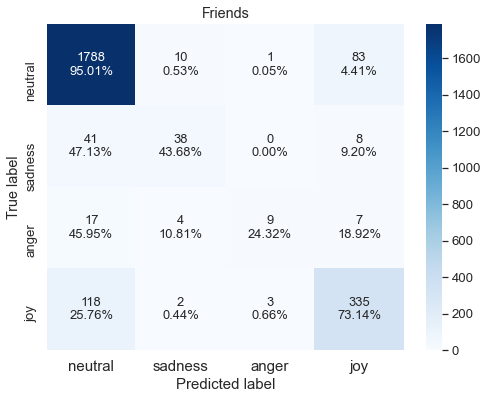

In [55]:
cm = confusion_matrix(model.y_true,model.y_pred)[0:len(focus_dict), 0:len(focus_dict)]
make_confusion_matrix(cm, figsize=(8,6), cbar=True, categories = focus_dict, title='Friends', percent=True)

# Per Class F1$_{macro}$ Score

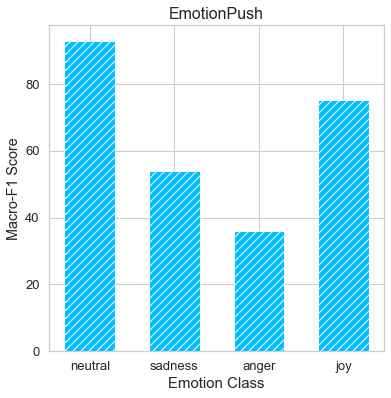

In [56]:
plot_per_Class_f1_score(args, focus_dict, score)

# Results Analysis
 - We perform a number of experiments to get better understanding of our results and the capabalities of our model 

# Effect of the Speaker, Dialogue Length 
In this section,  we investigate the effect of the number of speakers and dialogue length onERC model performance

In [57]:
if args.emoset == 'friends' or args.emoset == 'emorynlp':
    plot_F1_Score_against_speaker_count(df_test, model)

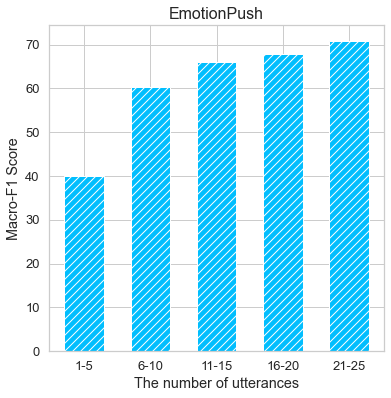

In [58]:
plot_F1_Score_against_dialogue_length(df_test, model)

# Influence of Utterance Positions in the Prediction
In this setting, we try to understand whether there is a general or dataset specific trend between the prediction f1-score and position of the utterances. We want to examine if utterances at the beginning of the dialogues are relatively easier to classify compared to the utterances at the middle or the utterances at the end.

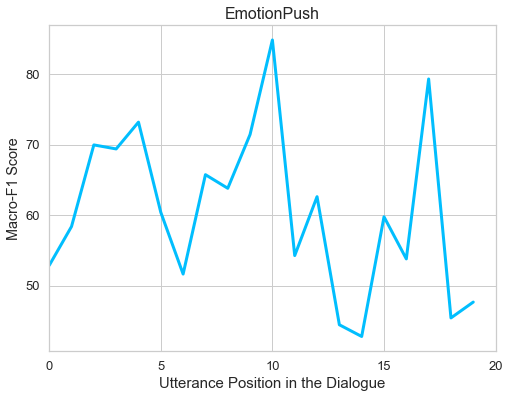

In [59]:
plot_F1_Score_against_utterance_length(df_test, model)

# Label Shift
We want to explore the label copying property which means consecutive utterances from the same speaker or different speakers often have the same emotion. Contextual models make correct predictions when utterances display such kind of continuation of the same label. But what happens when there is a change of label. We look at the following two different kind of shifts that could happen in the course of a dialogue
 - Intra-Speaker Shift : The label of the utterance is different from the label of the previous utterance from the same speaker
 - Inter-Speaker Shift: The label of the utterance is different from the label of the previous utterance from the non-target speaker
 
 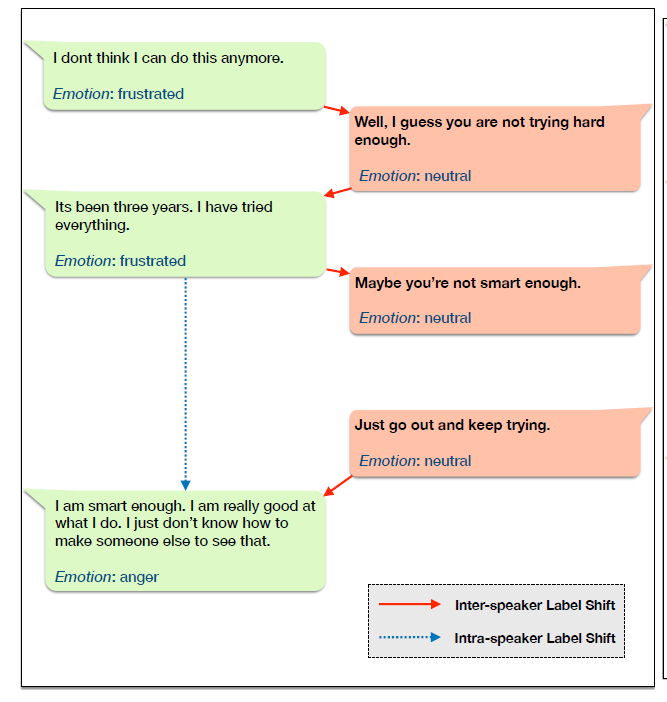

In [50]:
def get_intra_specific_label_shift(df):
    number_of_speakers_in_dialogue= []
    intraspeakers_shift_index_list = []
    count_intraspeakers_shift_list = []
    last_index_in_previous_dialogue = 0
    dialogue_id_list = list((df['dialogue_id'].unique()))
    for dialogue in dialogue_id_list:
        df_dialogue = df[(df.dialogue_id ==dialogue)]
        speakers_in_dialogue = (list(set(df_dialogue.speaker)))
        shift_count = 0
        for speaker in speakers_in_dialogue:
            indexs_to_check = df_dialogue[(df_dialogue.speaker ==speaker)].index
            first_index = True
            for index in indexs_to_check:
                current_label = df_dialogue.iloc[index-last_index_in_previous_dialogue].label
                if first_index:
                    prev_label = current_label
                    first_index = False
                    continue

                if  current_label != prev_label:
                    prev_label = current_label
                    intraspeakers_shift_index_list.append(index)
                    shift_count += 1

        last_index_in_previous_dialogue = df_dialogue.index[-1]+1
        count_intraspeakers_shift_list.append(shift_count)
    return (sorted(intraspeakers_shift_index_list), count_intraspeakers_shift_list)

def get_inter_specific_label_shift(df):
    interspeakers_shift_index_list = []
    count_interspeakers_shift_list = []
    last_index_in_previous_dialogue = 0
    dialogue_id_list = list((df['dialogue_id'].unique()))
    for dialogue in dialogue_id_list:
        df_dialogue = df[(df.dialogue_id ==dialogue)]
        shift_count = 0
        first_index = True
        for index in df_dialogue.index:
            current_label = df_dialogue.iloc[index-last_index_in_previous_dialogue].label
            if first_index:
                prev_label = current_label
                first_index = False
                continue
            if  current_label != prev_label:
                prev_label = current_label
                interspeakers_shift_index_list.append(index)
                shift_count += 1

        last_index_in_previous_dialogue = df_dialogue.index[-1]+1
        count_interspeakers_shift_list.append(shift_count)
    return (sorted(interspeakers_shift_index_list), count_interspeakers_shift_list)

def get_intra_specific_sentiment_shift(df):
    number_of_speakers_in_dialogue= []
    intraspeakers_shift_index_list = []
    count_intraspeakers_shift_list = []
    dialogue_id_list = list((df['dialogue_id'].unique()))
    for dialogue in dialogue_id_list:
        df_dialogue = df[(df.dialogue_id ==dialogue)]
        speakers_in_dialogue = (list(set(df_dialogue.speaker)))
        shift_count = 0
        for speaker in speakers_in_dialogue:
            indexs_to_check = df_dialogue[(df_dialogue.speaker ==speaker)].index
            first_index = True
            for index in indexs_to_check:
                current_sentiment = sentiment_labels_true[index]

                if first_index:
                    prev_sentiment = current_sentiment
                    first_index = False
                    continue

                if  current_sentiment != prev_sentiment:
                    prev_sentiment = current_sentiment
                    intraspeakers_shift_index_list.append(index)
                    shift_count += 1

        count_intraspeakers_shift_list.append(shift_count)
    return (sorted(intraspeakers_shift_index_list), count_intraspeakers_shift_list)

def get_inter_specific_sentiment_shift(df):
    interspeakers_shift_index_list = []
    count_interspeakers_shift_list = []
    dialogue_id_list = list((df['dialogue_id'].unique()))
    for dialogue in dialogue_id_list:
        df_dialogue = df[(df.dialogue_id ==dialogue)]
        shift_count = 0
        first_index = True
        for index in df_dialogue.index:
            current_sentiment = sentiment_labels_true[index]
            if first_index:
                prev_sentiment = current_sentiment
                first_index = False
                continue
            if  current_sentiment != prev_sentiment:
                prev_sentiment = current_sentiment
                interspeakers_shift_index_list.append(index)
                shift_count += 1


        count_interspeakers_shift_list.append(shift_count)
    return (sorted(interspeakers_shift_index_list), count_interspeakers_shift_list)

def cal_macro_recall(y_pred, y_true,focus_emo):
    TP = np.zeros([len(emo_dict.keys())], dtype=np.int64) # recall
    TP_FN = np.zeros([len(emo_dict.keys())], dtype=np.int64) # gold
    emo_predidx = y_pred
    emo_true = y_true

    for lb in range(len(emo_true)):
        idx = emo_true[lb]
        TP_FN[idx] += 1
        if idx in model.focus_emo:
            if emo_true[lb] == emo_predidx[lb]:
                TP[idx] += 1

    tp = TP[focus_emo]
    tp_fn = TP_FN[focus_emo]
    Recall = [np.round(tp/tp_fn*100, 2) if tp_fn>0 else 0 for tp,tp_fn in zip(tp,tp_fn)]
    score = np.round(sum(Recall) / len(Recall), 2)
    return score, Recall



In [51]:
intraspeakers_shift_index_list, count_intraspeakers_shift_list  = get_intra_specific_label_shift(df_test)
print('Intraspeakers Label Shift: Max = {} Avg. {}'.format(max(count_intraspeakers_shift_list), sum(count_intraspeakers_shift_list)/len(count_intraspeakers_shift_list)))

Intraspeakers Label Shift: Max = 16 Avg. 4.545


In [52]:
y_pred = [model.y_pred[i] for i in intraspeakers_shift_index_list]
y_true = [model.y_true[i] for i in intraspeakers_shift_index_list]
(macroF1, microF1) = calc_f1_score_1(y_pred, y_true,model.emo_dict, model.focus_emo)
print('IntraSpeaker Label Shift Macro_F1 {:2.2f} Micro_F1 {:2.2f}'.format(macroF1, microF1))

IntraSpeaker Label Shift Macro_F1 73.43 Micro_F1 82.93


In [53]:
interspeakers_shift_index_list, count_interspeakers_shift_list  = get_inter_specific_label_shift(df_test)
print('Interspeakers Label Shift: Max = {} Avg. {}'.format(max(count_interspeakers_shift_list), sum(count_interspeakers_shift_list)/len(count_interspeakers_shift_list)))

Interspeakers Label Shift: Max = 16 Avg. 5.025


In [54]:
y_pred = [model.y_pred[i] for i in interspeakers_shift_index_list]
y_true = [model.y_true[i] for i in interspeakers_shift_index_list]
(macroF1, microF1) = calc_f1_score_1(y_pred, y_true,model.emo_dict, model.focus_emo)
print('Interspeakers Label Shift Macro_F1 {:2.2f} Micro_F1 {:2.2f}'.format(macroF1, microF1))

Interspeakers Label Shift Macro_F1 71.92 Micro_F1 81.93


# Sentiment Shift
We further analyze the results for sentiment shift in intra- and inter-speaker level. For the emotion classification tasks, we
group the different emotion labels into three broad categories: i) positive sentiment group with emotions excited, happy, surprise, ii) negative sentiment group with emotions angry, disgust, fear, frustrated, sad, and iii) neutral sentiment group
with emotion neutral. We look at the following two different kind of sentiment shifts that could happen in the course of a dialogue
 - Intra-Speaker Sentiment Shift : The sentiment of the utterance is different from the sentiment of the previous utterance from the same speaker
 - Inter-Speaker Shift: The sentiment of the utterance is different from the sentiment of the previous utterance from the non-target speaker

In [60]:
sentiment_labels_true = [sentiment_dict[label] for label in df_test['label'].values]

In [61]:
intraspeakers_shift_index_list, count_intraspeakers_shift_list  = get_intra_specific_sentiment_shift(df_test)
print('Intraspeakers Sentiment Shift: Max = {} Avg. {}'.format(max(count_intraspeakers_shift_list), sum(count_intraspeakers_shift_list)/len(count_intraspeakers_shift_list)))

Intraspeakers Sentiment Shift: Max = 15 Avg. 3.525


In [62]:
y_pred = [model.y_pred[i] for i in intraspeakers_shift_index_list]
y_true = [model.y_true[i] for i in intraspeakers_shift_index_list]
(macroF1, microF1) = calc_f1_score_1(y_pred, y_true,model.emo_dict, model.focus_emo)
print('IntraSpeaker Label Shift Macro_F1 {:2.2f} Micro_F1 {:2.2f}'.format(macroF1, microF1))

IntraSpeaker Label Shift Macro_F1 72.73 Micro_F1 81.63


In [63]:
interspeakers_shift_index_list, count_interspeakers_shift_list  = get_inter_specific_sentiment_shift(df_test)
print('Interspeakers Sentiment Shift: Max = {} Avg. {}'.format(max(count_interspeakers_shift_list), sum(count_interspeakers_shift_list)/len(count_interspeakers_shift_list)))

Interspeakers Sentiment Shift: Max = 13 Avg. 3.875


In [64]:
y_pred = [model.y_pred[i] for i in interspeakers_shift_index_list]
y_true = [model.y_true[i] for i in interspeakers_shift_index_list]
(macroF1, microF1) = calc_f1_score_1(y_pred, y_true,model.emo_dict, model.focus_emo)
print('Interspeakers Sentiment Shift Macro_F1 {:2.2f} Micro_F1 {:2.2f}'.format(macroF1, microF1))

Interspeakers Sentiment Shift Macro_F1 71.36 Micro_F1 80.51


# Performance for n-gram Label Patterns
We perform a detailed study to understand whether n-gram label patterns that are frequently encountered by the learning algorithm during training, are more likely to be predicted correctly during evaluation

In [65]:
def get_label_list (df):
    label_list= []
    dummy_ele = ['dummy']
    dialogue_id_list = list((df['dialogue_id'].unique()))
    for dialogue in dialogue_id_list:
        df_dialogue = df[(df.dialogue_id ==dialogue)]
        label_list.extend(df_dialogue.label)
        label_list.extend(dummy_ele)
    return label_list

def get_ngram_label_shift(ngram_list, df):
    ngram_index_list = []
    count_ngram_label_list = []
    last_index_in_previous_dialogue = 0
    dialogue_id_list = list((df['dialogue_id'].unique()))
    for dialogue in dialogue_id_list:
        df_dialogue = df[(df.dialogue_id ==dialogue)]
        shift_count = 0
        first_index = True
        for index in df_dialogue.index:
            if (index + len(ngram_list) -1) > list(df_dialogue.index)[-1]:
                break
           
            if(list(df_dialogue.iloc[index-last_index_in_previous_dialogue : index-last_index_in_previous_dialogue + len(ngram_list)].label)) == ngram_list :
                ngram_index_list.extend(list(range(index,index + len(ngram_list))))
                shift_count += 1

        last_index_in_previous_dialogue = df_dialogue.index[-1]+1
        count_ngram_label_list.append(shift_count)
    return sorted(list(set(ngram_index_list))), sum(count_ngram_label_list)

def get_training_ngram_list(df_train, df_val, ngram_length_list):
    train_label_list  = get_label_list (df_train)
    train_label_list.extend(get_label_list(df_val))
    train_ngram_list = []
    for n in ngram_length_list:
        ngram_dict = {}
        bagofWords = nltk.ngrams(train_label_list,n)
        train_fdist = nltk.FreqDist(bagofWords)
        for k, v in train_fdist.items():
            if(set(k).issubset(set(model.focus_dict)))and (v > 2):
                ngram_dict[k] = [v,np.round((v/sum(train_fdist.values())*100), 2)]
        train_ngram_dict_sorted = {k:v for k,v in sorted(ngram_dict.items(), key=lambda item:item[1][1], reverse=True)}
        train_ngram_list.append(train_ngram_dict_sorted)
    
    return train_ngram_list

def get_test_ngram_list (df_test,train_ngram_list, ngram_length_list):
    test_ngram_list = []
    test_label_list = get_label_list (df_test)
    for i in range (len(ngram_length_list)):
        n = ngram_length_list[i]
        test_ngram_dict =  {}
        test_bag_of_words= nltk.ngrams(test_label_list,n)
        test_fdist = nltk.FreqDist(test_bag_of_words)
        for k, v in test_fdist.items():
            if (v < 2):
                continue
            if(set(k).issubset(set(model.focus_dict))) and (set(list((k, k))).issubset(set(list(train_ngram_list[i].keys())))):
                test_ngram_dict[k] = [v,np.round((v/sum(test_fdist.values())*100), 2)]
       
        test_ngram_dict_sorted = {k:v for k,v in sorted(test_ngram_dict.items(), key=lambda item:item[1][1], reverse=True)}
        test_ngram_list.append(test_ngram_dict_sorted)
    return test_ngram_list
    
def create_test_score_dataframe(train_ngram_list, test_ngram_list, df_test, ngram_length_list):
    column_list = list(('occurence_in_train', 'test_score'))
    df_list = []
    for i in range (len(ngram_length_list)):
        df_list.append(pd.DataFrame(columns = column_list))
        for k1,v1 in test_ngram_list[i].items():
            ngram_index, count  = get_ngram_label_shift(list(k1) , df_test)
            assert(count == v1[0])
            y_pred = [model.y_pred[i] for i in ngram_index]
            y_true = [model.y_true[i] for i in ngram_index]
            score, Recall = cal_macro_recall(y_pred, y_true, [model.emo_dict[k2] for k2 in list(set(k1))])
            occurence_score = train_ngram_list[i][k1][1]
            new_row = {'occurence_in_train':occurence_score, 'test_score':score}
            df_list[i] = df_list[i].append(new_row, ignore_index=True)
    return df_list
  

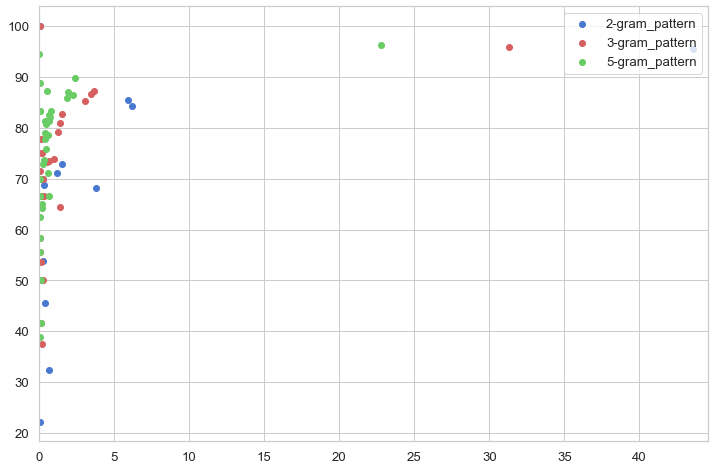

In [66]:
ngram_length_list = [2, 3, 4]
train_ngram_list = get_training_ngram_list(model.df_train, model.df_val,ngram_length_list )
test_ngram_list = get_test_ngram_list(model.df_test,train_ngram_list, ngram_length_list )
df_list = create_test_score_dataframe(train_ngram_list, test_ngram_list, model.df_test, ngram_length_list)
plot1 = plt.scatter(df_list[0]['occurence_in_train'], df_list[0]['test_score'], color = 'b')
plot2 = plt.scatter(df_list[1]['occurence_in_train'], df_list[1]['test_score'], color = 'r')
plot3 = plt.scatter(df_list[2]['occurence_in_train'], df_list[2]['test_score'], color = 'g')
plt.xlim ((0, max (df_list[0]['occurence_in_train']+1)))
plt.legend((plot1, plot2, plot3),
           ('2-gram_pattern', '3-gram_pattern', '5-gram_pattern'),
           loc='upper right')

# Context Shuffling
To understand the importance of context, we try to classify the correct label after shuffling the utterances with in a dialogue. For example, a dialogue having utterance sequence of {u1;u2;u3;u4} is shuffled to {u4;u1;u3;u2}. This shuffling is carried out randomly, resulting in an utterance sequence whose order is different from the original sequence. We implement 3 shuffling strategies

- dialogues in train and validation sets are shuffled, dialogues in test set are kept unchanged
- dialogues in train and validation sets are unchanged, dialogues in test set are shuffled
- dialogues in train and validation and test set are shuffled. 

We found that, whenever there is some shuffling in train, validation, or test set, the performance decreases a few points. The performance drop is highest when the dialogues in train and validation sets are kept unchanged and dialogues in test set are shuffled

In [20]:
def shuffle_dataframe(df):
    dialogue_id_list = list((df['dialogue_id'].unique()))
    df_shuffled =  pd.DataFrame(columns = list(df.columns))
    for dialogue in dialogue_id_list:
        df_dialogue = df[(df.dialogue_id ==dialogue)].copy(deep = True)
        df_dialogue = df_dialogue.sample(frac=1)
        df_shuffled = df_shuffled.append(df_dialogue)
    df_shuffled =df_shuffled.reset_index(drop=True)
    return df_shuffled

def shuffling_performance(emo_dict, focus_dict, args, df_train, df_val, df_test):
    model_shuffle = EmotionModel(emo_dict, focus_dict, args, df_train, df_val, df_test, verbosity = 0)
    model_shuffle = model_shuffle.cuda(args.device)
    trainer_shuffle = train_model(model_shuffle)
    F1_score  = test_model(trainer_shuffle, model_shuffle)
    print(F1_score)

In [21]:
model.args.epoch = 2
df_train_shuffled = shuffle_dataframe(df_train)
df_val_shuffled = shuffle_dataframe(df_val)
df_test_shuffled = shuffle_dataframe(df_test)

In [69]:
shuffling_performance(model.emo_dict, model.focus_dict, model.args, df_train_shuffled, df_val_shuffled, df_test )

Speaker Embedding is Enabled
Max number of speakers in a dialgue = 364
loss weights = tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
class weights = tensor([0.7844, 0.0427, 0.0103, 0.1626], device='cuda:0')
In function DistilBertForSequenceClassification


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type                     | Params
----------------------------------------------------------------------
0 | sentence_embeds_model    | sentence_embeds_model    | 66.4 M
1 | context_classifier_model | context_classifier_model | 86.0 M
----------------------------------------------------------------------
152 M     Trainable params
0         Non-trainable params
152 M     Total params
609.457   Total estimated model params size (MB)


using distill-uncased tokenizer


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42


using distill-uncased tokenizer


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Metric valid_loss improved. New best score: 0.074



In Test Model


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


using distill-uncased tokenizer


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



[{'valid_loss': 0.08070061355829239, 'valid_ac_unweighted': 63.75, 'macroF1': 69.34, 'microF1': 88.03, 'microF1_per_class': {'0': 92.76, '1': 57.34, '2': 46.43, '3': 76.11}}]


## Scenario 2
- dialogues in train and validation sets are shuffled, dialogues in test set are kept unchanged

In [22]:
shuffling_performance(model.emo_dict, model.focus_dict, model.args, df_train, df_val, df_test_shuffled )

Speaker Embedding is Enabled
Max number of speakers in a dialgue = 364
loss weights = tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
class weights = tensor([0.7844, 0.0427, 0.0103, 0.1626], device='cuda:0')
In function DistilBertForSequenceClassification


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type                     | Params
----------------------------------------------------------------------
0 | sentence_embeds_model    | sentence_embeds_model    | 66.4 M
1 | context_classifier_model | context_classifier_model | 86.0 M
----------------------------------------------------------------------
152 M     Trainable params
0         Non-trainable params
152 M     Total params
609.457   Total estimated model params size (MB)


using distill-uncased tokenizer


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42


using distill-uncased tokenizer


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Metric valid_loss improved. New best score: 0.076



In Test Model


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


using distill-uncased tokenizer


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



[{'valid_loss': 0.08499559015035629, 'valid_ac_unweighted': 59.86, 'macroF1': 64.42, 'microF1': 86.97, 'microF1_per_class': {'0': 92.27, '1': 54.93, '2': 31.58, '3': 74.22}}]


## Scenario 3
- dialogues in train and validation and test set are shuffled. 

In [23]:
shuffling_performance(model.emo_dict, model.focus_dict, model.args, df_train_shuffled, df_val_shuffled, df_test_shuffled )

Speaker Embedding is Enabled
Max number of speakers in a dialgue = 364
loss weights = tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
class weights = tensor([0.7844, 0.0427, 0.0103, 0.1626], device='cuda:0')
In function DistilBertForSequenceClassification


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type                     | Params
----------------------------------------------------------------------
0 | sentence_embeds_model    | sentence_embeds_model    | 66.4 M
1 | context_classifier_model | context_classifier_model | 86.0 M
----------------------------------------------------------------------
152 M     Trainable params
0         Non-trainable params
152 M     Total params
609.457   Total estimated model params size (MB)


using distill-uncased tokenizer


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42


using distill-uncased tokenizer


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Metric valid_loss improved. New best score: 0.074



In Test Model


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


using distill-uncased tokenizer


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



[{'valid_loss': 0.0806371197104454, 'valid_ac_unweighted': 63.49, 'macroF1': 68.13, 'microF1': 87.95, 'microF1_per_class': {'0': 92.77, '1': 56.38, '2': 44.07, '3': 76.08}}]


# Speaker-specific Context Control
To understand the importance of context, we tried following startigies. 
- Treat each conversation as individual sentence without considering the context. 
- Limit the context to maximum of 5 utterances per conversation
- when classifying a target utterance from speaker A, we drop the utterances of the speaker B from the context and vice versa.



In [31]:
model.context_classifier_model.context_experiment_flag= True
df_shuffled = df_test.copy(deep = True)
df_shuffled['dialogue_id'] = df_shuffled.index
dataset = CustomDataset( df_shuffled, model.max_number_of_speakers_in_dialogue, model.emo_dict, model.encoder, model.args)

using distill-uncased tokenizer


## Scenario 1
- Treat each conversation as individual sentence without considering the context.

In [32]:
test_loader = DataLoader(dataset, 1, shuffle=False, num_workers=0)
trainer.test(test_dataloaders =  test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


('val_loss', tensor(0.0821, device='cuda:0'))
('preds', array([1916,   77,   12,  459], dtype=int64))
('labels', array([1882,   87,   37,  458], dtype=int64))
('tp', array([1757,   46,   10,  343], dtype=int64))
('fp', array([159,  31,   2, 116], dtype=int64))
('fn', array([125,  41,  27, 115], dtype=int64))
('acc_per_class', [93.36, 52.87, 27.03, 74.89])
('acc_unweighted', 62.04)
('acc_weighted', tensor(87.9400, device='cuda:0'))
('microRecall', 87.5)
('macroRecall', 62.04)
('microPrecision', 87.5)
('macroPrecision', 77.38)
('microF1_score', 87.5)
('macroF1_score', 68.87)
('macroF1_per_class', [92.52, 56.1, 40.82, 74.81])

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'macroF1': 68.87,
 'microF1': 87.5,
 'microF1_per_class': {'0': 92.52, '1': 56.1, '2': 40.82, '3': 74.81},
 'valid_ac_unweighted': 62.04,
 'valid_loss': 0.08208133280277252}
--------------------------------------------------------------------------------


[{'valid_loss': 0.08208133280277252,
  'valid_ac_unweighted': 62.04,
  'macroF1': 68.87,
  'microF1': 87.5,
  'microF1_per_class': {'0': 92.52, '1': 56.1, '2': 40.82, '3': 74.81}}]

## Scenario 2
- Limit the context to maximum of 5 utterances per conversation

In [33]:
test_loader = DataLoader(dataset, 5, shuffle=False, num_workers=0)
trainer.test(test_dataloaders =  test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


('val_loss', tensor(0.0840, device='cuda:0'))
('preds', array([1876,   75,   12,  501], dtype=int64))
('labels', array([1882,   87,   37,  458], dtype=int64))
('tp', array([1737,   46,    9,  360], dtype=int64))
('fp', array([139,  29,   3, 141], dtype=int64))
('fn', array([145,  41,  28,  98], dtype=int64))
('acc_per_class', [92.3, 52.87, 24.32, 78.6])
('acc_unweighted', 62.02)
('acc_weighted', tensor(87.6900, device='cuda:0'))
('microRecall', 87.34)
('macroRecall', 62.02)
('microPrecision', 87.34)
('macroPrecision', 75.2)
('microF1_score', 87.34)
('macroF1_score', 67.98)
('macroF1_per_class', [92.44, 56.79, 36.73, 75.08])

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'macroF1': 67.98,
 'microF1': 87.34,
 'microF1_per_class': {'0': 92.44, '1': 56.79, '2': 36.73, '3': 75.08},
 'valid_ac_unweighted': 62.02,
 'valid_loss': 0.08399830013513565}
--------------------------------------------------------------------------------


[{'valid_loss': 0.08399830013513565,
  'valid_ac_unweighted': 62.02,
  'macroF1': 67.98,
  'microF1': 87.34,
  'microF1_per_class': {'0': 92.44, '1': 56.79, '2': 36.73, '3': 75.08}}]

## Scenario 3
- Treat each conversation as individual sentence without considering the context.

In [34]:
speaker_list = df_test['speaker'].value_counts()[:6].index.tolist()


In [35]:
df_without_interspeaker_context = {}

for speaker in speaker_list:
    df_without_interspeaker_context[speaker] = df_test[(df_test.speaker == speaker)].reset_index(drop=True)
    dialogue_id_list = list((df_without_interspeaker_context[speaker]['dialogue_id'].unique()))
    i = 0
    for dialogue in dialogue_id_list:
        df_without_interspeaker_context[speaker].loc[df_without_interspeaker_context[speaker].dialogue_id== dialogue, 'dialogue_id'] = i 
        i = i+1

In [36]:
avg_f1_score_macro = 0
avg_f1_score_micro = 0
model.context_classifier_model.context_experiment_flag= False
for speaker in speaker_list:
    dataset = CustomDataset( df_without_interspeaker_context[speaker], model.max_number_of_speakers_in_dialogue, model.emo_dict, model.encoder, model.args)
    test_loader = DataLoader(dataset, model.args.batch_size, shuffle=False, num_workers=0)
    score = trainer.test(test_dataloaders =  test_loader)
    print('Micro/Macro F1 Score for Speaker {} is {} {}'.format(speaker, score[0]['macroF1'],  score[0]['microF1'] ))
    avg_f1_score_macro += score[0]['macroF1']
    avg_f1_score_micro += score[0]['microF1']

print('Macro F1 Score without Intraspeaker Context {}'.format(avg_f1_score_macro/len(speaker_list)))
print('Micro F1 Score without Intraspeaker Context {}'.format(avg_f1_score_micro/len(speaker_list)))

using distill-uncased tokenizer


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


('val_loss', tensor(0.0550, device='cuda:0'))
('preds', array([145,   9,   0,  49], dtype=int64))
('labels', array([148,   9,   0,  46], dtype=int64))
('tp', array([138,   7,   0,  39], dtype=int64))
('fp', array([ 7,  2,  0, 10], dtype=int64))
('fn', array([10,  2,  0,  7], dtype=int64))
('acc_per_class', [93.24, 77.78, 0.0, 84.78])
('acc_unweighted', 63.95)
('acc_weighted', tensor(90.2400, device='cuda:0'))
('microRecall', 90.64)
('macroRecall', 63.95)
('microPrecision', 90.64)
('macroPrecision', 63.14)
('microF1_score', 90.64)
('macroF1_score', 63.54)
('macroF1_per_class', [94.2, 77.78, 0.0, 82.1])

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'macroF1': 63.54,
 'microF1': 90.64,
 'microF1_per_class': {'0': 94.2, '1': 77.78, '2': 0.0, '3': 82.1},
 'valid_ac_unweighted': 63.95,
 'valid_loss': 0.05498328432440758}
--------------------------------------------------------------------------------
Micro/Macro F1 Score for Spea

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


('val_loss', tensor(0.0637, device='cuda:0'))
('preds', array([113,   2,   0,  16], dtype=int64))
('labels', array([115,   4,   0,  12], dtype=int64))
('tp', array([109,   2,   0,  10], dtype=int64))
('fp', array([4, 0, 0, 6], dtype=int64))
('fn', array([6, 2, 0, 2], dtype=int64))
('acc_per_class', [94.78, 50.0, 0.0, 83.33])
('acc_unweighted', 57.03)
('acc_weighted', tensor(90.0300, device='cuda:0'))
('microRecall', 92.37)
('macroRecall', 57.03)
('microPrecision', 92.37)
('macroPrecision', 64.74)
('microF1_score', 92.37)
('macroF1_score', 60.64)
('macroF1_per_class', [95.61, 66.67, 0.0, 71.43])

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'macroF1': 60.64,
 'microF1': 92.37,
 'microF1_per_class': {'0': 95.61, '1': 66.67, '2': 0.0, '3': 71.43},
 'valid_ac_unweighted': 57.03,
 'valid_loss': 0.06370683759450912}
--------------------------------------------------------------------------------
Micro/Macro F1 Score for Speaker 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


('val_loss', tensor(0.0958, device='cuda:0'))
('preds', array([48,  5,  0, 47], dtype=int64))
('labels', array([46,  7,  3, 44], dtype=int64))
('tp', array([42,  4,  0, 43], dtype=int64))
('fp', array([6, 1, 0, 4], dtype=int64))
('fn', array([4, 3, 3, 1], dtype=int64))
('acc_per_class', [91.3, 57.14, 0.0, 97.73])
('acc_unweighted', 61.54)
('acc_weighted', tensor(89.9500, device='cuda:0'))
('microRecall', 89.0)
('macroRecall', 61.54)
('microPrecision', 89.0)
('macroPrecision', 64.75)
('microF1_score', 89.0)
('macroF1_score', 63.1)
('macroF1_per_class', [89.36, 66.66, 0.0, 94.51])

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'macroF1': 63.1,
 'microF1': 89.0,
 'microF1_per_class': {'0': 89.36, '1': 66.66, '2': 0.0, '3': 94.51},
 'valid_ac_unweighted': 61.54,
 'valid_loss': 0.09583236277103424}
--------------------------------------------------------------------------------
Micro/Macro F1 Score for Speaker 671792823 is 63.1 8

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


('val_loss', tensor(0.0871, device='cuda:0'))
('preds', array([69,  2,  0, 26], dtype=int64))
('labels', array([64,  5,  0, 28], dtype=int64))
('tp', array([61,  2,  0, 22], dtype=int64))
('fp', array([8, 0, 0, 4], dtype=int64))
('fn', array([3, 3, 0, 6], dtype=int64))
('acc_per_class', [95.31, 40.0, 0.0, 78.57])
('acc_unweighted', 53.47)
('acc_weighted', tensor(89.2400, device='cuda:0'))
('microRecall', 87.63)
('macroRecall', 53.47)
('microPrecision', 87.63)
('macroPrecision', 68.26)
('microF1_score', 87.63)
('macroF1_score', 59.97)
('macroF1_per_class', [91.73, 57.14, 0.0, 81.48])

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'macroF1': 59.97,
 'microF1': 87.63,
 'microF1_per_class': {'0': 91.73, '1': 57.14, '2': 0.0, '3': 81.48},
 'valid_ac_unweighted': 53.47,
 'valid_loss': 0.0871487557888031}
--------------------------------------------------------------------------------
Micro/Macro F1 Score for Speaker 10000324592735

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


('val_loss', tensor(0.0529, device='cuda:0'))
('preds', array([65,  3,  0, 10], dtype=int64))
('labels', array([66,  3,  1,  8], dtype=int64))
('tp', array([63,  1,  0,  8], dtype=int64))
('fp', array([2, 2, 0, 2], dtype=int64))
('fn', array([3, 2, 1, 0], dtype=int64))
('acc_per_class', [95.45, 33.33, 0.0, 100.0])
('acc_unweighted', 57.2)
('acc_weighted', tensor(92.5500, device='cuda:0'))
('microRecall', 92.31)
('macroRecall', 57.2)
('microPrecision', 92.31)
('macroPrecision', 52.56)
('microF1_score', 92.30999999999999)
('macroF1_score', 54.78)
('macroF1_per_class', [96.18, 33.33, 0.0, 88.89])

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'macroF1': 54.78,
 'microF1': 92.30999999999999,
 'microF1_per_class': {'0': 96.18, '1': 33.33, '2': 0.0, '3': 88.89},
 'valid_ac_unweighted': 57.2,
 'valid_loss': 0.052932120859622955}
--------------------------------------------------------------------------------
Micro/Macro F1 Score fo

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


('val_loss', tensor(0.1084, device='cuda:0'))
('preds', array([55,  1,  2, 16], dtype=int64))
('labels', array([47,  3,  1, 23], dtype=int64))
('tp', array([45,  1,  1, 14], dtype=int64))
('fp', array([10,  0,  1,  2], dtype=int64))
('fn', array([2, 2, 0, 9], dtype=int64))
('acc_per_class', [95.74, 33.33, 100.0, 60.87])
('acc_unweighted', 72.48)
('acc_weighted', tensor(87.4500, device='cuda:0'))
('microRecall', 82.43)
('macroRecall', 72.48)
('microPrecision', 82.43)
('macroPrecision', 79.83)
('microF1_score', 82.43)
('macroF1_score', 75.98)
('macroF1_per_class', [88.23, 50.0, 66.67, 71.8])

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'macroF1': 75.98,
 'microF1': 82.43,
 'microF1_per_class': {'0': 88.23, '1': 50.0, '2': 66.67, '3': 71.8},
 'valid_ac_unweighted': 72.48,
 'valid_loss': 0.10837429016828537}
--------------------------------------------------------------------------------
Micro/Macro F1 Score for Speaker 100000